# spin transformations on discrete surfaces
Tim Tyree<br>
12.30.2022

This notebook works along with the paper of the same name by Crane, Pinkall, and Schröder (2011).

In [1]:
from lib.my_initialization import *

In [2]:
plt.plot([4]*3)
plt.close()
#reset matplotlib
import matplotlib as mpl
sns.reset_orig()
mpl.rc_file_defaults()
#set randomization seed
np.random.seed(42)
#consider darkmode
darkmode=False
if darkmode:
    # For darkmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
    
%load_ext autoreload
%autoreload 2

In [3]:
import scipy.io as sio
from IPython.display import IFrame


In [4]:
import scipy
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import lsqr

# define module

In [5]:
def get_colors_trimesh(inp, colormap=None, vmin=None, vmax=None):
    """inp is a 1D numpy array that is mapped to a plt.cm.jet if colormap is None.
    
    Example Usage:
colors = get_colors_trimesh(rho, plt.cm.jet)
mesh = trimesh.Trimesh(vertices=vert,faces=tria,face_colors=colors)
    """
    
    if colormap is None:
        colormap = plt.cm.jet
    # norm = plt.Normalize()
    # colors = plt.cm.jet(norm(rho))
    # colors = plt.cm.jet(np.linspace(0,1,len(dz)))
    norm = plt.Normalize(vmin, vmax)
    colors = colormap(norm(inp))
    return (255*colors/np.max(colors)).astype('uint8')#[:,0,:]


In [6]:
@njit
def jiH(pnt):
    """jiH castes a cartesion point, pnt, to a real quaternionic representation."""
    a=pnt[0]; b=pnt[1]; c=pnt[2]; d=pnt[3];
    h = np.array([
        [a, -b, -c, -d],
        [b,  a, -d,  c],
        [c,  d,  a, -b],
        [d, -c,  b,  a]])
    return h


In [7]:
def map_lam_real(lam,V,T,printing=True,**kwargs):
    """map_lam_real maps the (eigen)vector, lam, from the real representation of vector-quaternions to 
    vetex representation of map, L,ome.
    
    Example Usage:
L,ome=map_lam_real(lam,V,T,printing=True)#,**kwargs)
    """
    #input: V,T,lam
    #output: L,ome
    nT=T.shape[0]
    nV=V.shape[0]
    #transcribe eigensolution to output mesh.
    ome=np.zeros(4*nV)
    # L  =scipy.sparse.csc_matrix(4*nV,4*nV) #<<Q: is this sparse faster?
    L  =np.zeros((4*nV,4*nV))
    # L  =sparse(4*nV,4*nV);
    num_steps=nT-1
    update_printbar_every=int(np.around(nT/20))
    step=0
    # for c1 in range(1,nT): # for c1=1:nT
    # for c1 in range(nT+1): # for c1=1:nT #<<< Index Error
    # for c1 in range(nT-1): # for c1=1:nT
    # #Q: is ^this the problem?
    # #A: it appears not...
    for c1 in range(nT): # for c1=1:nT
        for c2 in range(3): #for c2=1:3
            k0 = T[c1,(c2-1)%3]
            k1 = T[c1,(c2+0)%3]
            k2 = T[c1,(c2+1)%3]
            u1=V[k1]-V[k0]
            u2=V[k2]-V[k0]
            cta = np.dot (u1,u2) / np.linalg.norm (np.cross (u1,u2) )
            h=jiH(np.array([0.5*cta, 0, 0, 0]));
            # write to global vertex representation
            ooow = np.hstack([np.concatenate([h, -h]),
                              np.concatenate([-h, h])]) # [[h -h],-[h h]]
            ini=np.hstack([k1*4+plc,  k2*4+plc])
            # #ini=np.hstack([k2*4+plc,  k1*4+plc]) #global swap?
            L[np.ix_(ini,ini)] += ooow  # L(ini,ini) = L(ini,ini) + [[h -h],-[h h]]
            # ooow_= np.concatenate([ooow[1],ooow[2],ooow[0]],axis=2)
            # oooow = np.vstack([ooow_[1],ooow_[2],ooow_[0]])
            #L[np.ix_(ini,ini)] += oooow
            if k1>k2: #swap s.t. k3 is tmp
                k3=k1; k1=k2; k2=k3;
            lm1=jiH(lam[k1*4+plc])
            lm2=jiH(lam[k2*4+plc])
            edv=jiH(np.concatenate([np.array([0]),V[k2]-V[k1]]))
    #         ti1 = (lm1*edv)@lm1/3.   + (lm2*edv)@lm2/3.   + (lm1*edv)@lm2/6. + (lm2*edv)@lm1/6.
    #         ti1 = lm1*edv@lm1/3.   + lm2*edv@lm2/3.   + lm1*edv@lm2/6. + lm2*edv@lm1/6.
    #         ti1 = lm1*(edv@lm1)/3. + lm2*(edv@lm2)/3. + lm1*(edv@lm2)/6. + lm2*(edv@lm1)/6.
    #         ti1 = lm1@edv@lm1/3. + lm2@edv@lm2/3. + lm1@edv@lm2/6. + lm2@edv@lm1/6.
            #ti1 = (lm1@edv)@lm1/3.   + (lm2@edv)@lm2/3.   + (lm1@edv)@lm2/6. + (lm2@edv)@lm1/6.# <<< clearly wrong
            ti1 = (lm1.T@edv)@lm1/3.   + (lm2.T@edv)@lm2/3.   + (lm1.T@edv)@lm2/6. + (lm2.T@edv)@lm1/6.
            ti1 *= -1.
            #Q: which of ^these is right?
            #A: left to right, * and then @
            # til=lm1'*edv*lm1/3 + lm1'*edv*lm2/6 + lm2'*edv*lm1/6 + lm2'*edv*lm2/3;
    #         ome[k1*4+plc] = ome[k1*4+plc]-0.5*cta*ti1[0] #<<<wrong sign for rotations
            ome[k1*4+plc] = ome[k1*4+plc]-0.5*cta*ti1[:,0]  #<<< this one agrees with matlab? it looks like it gives the wrong sign to rotation
            #Q: which of ^these is right?
            # ome(k1*4+plc,1)=ome(k1*4+plc,1)-cta*til(:,1)/2;
    #         ome[k2*4+plc] = ome[k2*4+plc]+0.5*cta*ti1[0]#<<<wrong sign for rotations
            ome[k2*4+plc] = ome[k2*4+plc]+0.5*cta*ti1[:,0]  #<<< this one agrees with matlab? it looks like it gives the wrong sign to rotation
            #Q: which of ^these is right?
            # ome(k2*4+plc,1)=ome(k2*4+plc,1)+cta*til(:,1)/2;
            #Q: am I certain that i use ome[k2*4+plc] and not ome[k2*4+plc,0]??
        #print progress bar
        if printing:
            step+=1
            if step%update_printbar_every==0:
                printProgressBar(step+1, num_steps, prefix = 'Progress:', suffix = 'Complete', length = 50)
    return L,ome

In [185]:
def map_real_lam_to_vertices(lam,V,T,printing=True,use_return_Lp=True,**kwargs):
    """map_real_lam_to_vertices does essentially a linear algebra solve to 
    - compute the linear map of the solution vector, lam,
    - on triangular mesh with 
        - vertices, V (N,3 numpy.array), and
        - faces, T (N,3, numpy.array)   
    is this really 2 seconds per linear algebra solve? yes. 
    UNLESS if you're out of virtual memory stored in swap ram.

    minimizes the least square of $ | Lp . x - ome | ^ 2 $
    
    kwargs are passed to scipy.sparse.linalg.lsqr

    Example Usage:
x,Lp,ome = map_real_lam_to_vertices(lam,V,T)#,printing=True,use_return_Lp=True,**kwargs)
    """
    L,ome=map_lam_real(lam,V,T,printing=printing)#,**kwargs)
    # print(f"{np.around(L[:10,:10],2)=}")
    # print(f"{ome[:6]=}")
    Lp=np.roll(np.roll(L,3,axis=0),3,axis=1) #bc of plc indexing...
    omep=np.roll(ome,3) #bc of plc indexing...
    #center input
    ome = omep.reshape((nV,4))
    ome = ome - np.broadcast_to(np.mean(ome,axis=0), shape=(nV,4), subok=False) #note subok=True would be needed for numpy-quaternion entries in ome.
    ome = ome.flatten()
    A = csc_matrix(Lp, dtype=float) #<<< looks fastest for demo rho
    # A = scipy.sparse.bsr_matrix(Lp, dtype=float) #<<< alternative sparse repr
    # A = scipy.sparse.csr_matrix(Lp, dtype=float) #<<< alternative sparse repr
    #solve the linear system in the least square
    b = np.array(ome, dtype=float)
    if printing:
        print(f"\nPerforming linear algebra solve...")
    x, istop, itn, normr = scipy.sparse.linalg.lsqr(A, b, **kwargs)[:4]
    if use_return_Lp:
        if printing:
            print(f"linear solve complete!\nthe number of iterations used for linear algebra solve: {istop=}")
            print(f"returning Lp,ome: {Lp.shape=}, {ome.shape=}")
            print(f"{np.min(L)=:7f},{np.max(L)=:7f}")
            print(f"{np.min(ome)=:7f},{np.max(ome)=:7f}")
        return x,Lp,ome
    else:
        return x,None,None
    

In [169]:
def comp_groundstate_eigenvector_sparse(E):
    """comp_groundstate_eigenvector_sparse 
    appears faster than banded solvers...
    
    Example Usage:
lam,cnv = comp_groundstate_eigenvector_sparse(E)
    
    """
    # Eab = decomp_banded_matrix(E)
    E_sparse=scipy.sparse.csc_matrix(E,dtype=float)
    lam=np.zeros(4*nV)
    lam[::4]=1.
    b=lam
    # num_steps=11
    # for step in range(num_steps):
    #     cnv=lam
    #Q: what's the fastest way to compute x vs. x2 or x3
    x2 =scipy.sparse.linalg.lsqr(E_sparse,b)[0] #lam=lam/E
    # x3 =solveh_banded(Eab,b)#,lower=False)#,**kwargs) #lam =mldivide(lam,ab)
    #Q: what's the fastest way to compute x vs. x2 or x3
    # A: x2
    lam=x2.copy()
    # lam=x3.copy()
    cnv=b.copy()
    return lam,cnv

In [172]:
def comp_groundstate_eigenvector_inverse(E,num_steps=11,printing=True):
    """computes lam = lam . Einv num_steps times.
    comp_groundstate_eigenvector_inverse has a relatively slow run time...
    
    Example Usage:
lam,cnv,Einv = comp_groundstate_eigenvector_inverse(E)
res=(lam@E)/lam; 
print(f'mean: {np.mean(res):e}, var:  {np.var(res):e}, delta: {np.linalg.norm(cnv-lam):e}')
    """
    #sparse soln:
    # mean: -1.825385e-04, var:  1.688050e-04, delta: 2.156203e+05
    # Q: how does lam look?
    # A: great! 
    #banded soln: ?? second run time.... does it crash the kernel?
    # mean: ??
    # Q: how does lam look?
    # A: ??
    #omverse soln:
    #3 minute runtime for 11 epochs
    #isn't this supposed to be faster
    #input: E,nV=E.shape[0]/4
    #output: lam
    lam=np.zeros(4*nV)
    lam[::4]=1.
    # lam[1::4]=1.
    # lam[-1::4]=1.
    # lam[3::4]=1.
    # lam/=np.linalg.norm(lam)
    # lam+=1.
    #Q: is ^this right?
    #Q is this better? 
    # ab = decomp_banded_matrix(E)
    # ab = decomp_banded_matrix(E)
    # E_sparse=scipy.sparse.csc_matrix(E,dtype=float)
    Einv=np.linalg.inv(E)
    for step in range(num_steps):
        cnv=lam

        lam = lam@Einv
        #lam =scipy.sparse.linalg.lsqr(E_sparse,lam)[0] #lam=lam/E
        #lam =solveh_banded(ab,lam)#,lower=False)#,**kwargs) #lam =mldivide(lam,ab)
        lam/=np.linalg.norm(lam);
        #print progress bar
        if printing:
            step+=1
            if step%update_printbar_every==0:
                printProgressBar(step+1, num_steps, prefix = 'Progress:', suffix = 'Complete', length = 50)
    return lam,cnv,Einv

In [ ]:
##############################################
# note directly used in final implentation
##############################################

In [8]:
from scipy.linalg import solveh_banded

def decomp_banded_matrix(A):
    """A is an NxN matrix as a 2D numpy array. entries may be objects.
    decomp_banded_matrix returns a 2D numpy array instance with D=the number of nontrivial bands.
    
    Example Usage:
ab = decomp_banded_matrix(A)
ab.shape
    """
    D=np.max(np.count_nonzero(A,axis=1))
    ab = np.zeros((D,A.shape[0]))
    for i in np.arange(1,D):
        ab[i,:] = np.concatenate((np.diag(A,k=i),np.zeros(i,)),axis=None)
    ab[0,:] = np.diag(A,k=0)
    return ab

def mldivide_banded(ab,x,lower=True,**kwargs):
    """
    Example Usage:
#input: E,nV=E.shape[0]/4
lam=np.zeros(4*nV)
lam[::4]=1.
# lam[1::4]=1.
# lam[-1::4]=1.
# lam[3::4]=1.
lam/=np.linalg.norm(lam)
# lam+=1.
#Q: is ^this right?
#Q is this better? 
ab = decomp_banded_matrix(E)
for c1 in range(11):
    cnv=lam
    #lam=lam/E as ab
    lam =solveh_banded(ab,lam,lower=lower,**kwargs) #lam =mldivide(lam,ab)
    lam/=np.linalg.norm(lam);
res=(lam@E)/lam; 
print(f'mean: {np.mean(res):e}, var:  {np.var(res):e}, delta: {np.linalg.norm(cnv-lam):e}')



    """
    return solveh_banded(ab,x,lower=lower,**kwargs)

def invh_banded(A, x):
    N = np.shape(A)[0]
    D = np.count_nonzero(A[0,:])
    ab = np.zeros((D,N))
    for i in np.arange(1,D):
        ab[i,:] = np.concatenate((np.diag(A,k=i),np.zeros(i,)),axis=None)
    ab[0,:] = np.diag(A,k=0)
    y = solveh_banded(ab,x,lower=True)
    return y

# y=invh_banded(E, np.ones())

# def invh_banded_simple(A, x):
#     N = np.shape(A)[0]
#     D = np.count_nonzero(A[0,:])
#     ab = np.zeros((D,N))
#     for i in np.arange(1,D):
#         ab[i,:] = np.concatenate((np.diag(A,k=i),np.zeros(i,)),axis=None)
#     ab[0,:] = np.diag(A,k=0)
#     y = solveh_banded(ab,x,lower=True)
#     return y

In [9]:
def AddLegend(ax=None,xy = (1.04,1.04),fontsize=15,loc='upper left',frameon=False,**kwargs):
    """AddLegend adds a legend to a matplotlib plot.

    Example Usage:
ax = AddLegend()#ax=None,xy = (1.04,1.04),fontsize=15,loc='upper left',frameon=False,**kwargs)

    Example Usage:
#format_plot
format_plot(xlabel='n',ylabel='Probability')
ax = AddLegend(ax,fontsize=fontsize-3,xy = (0.96,0.96), loc='upper right',frameon=False)#,**kwargs)
    """
    if ax is None:
        ax = plt.gca()
    return ax.legend(fontsize=fontsize,loc=loc, bbox_to_anchor = xy, frameon=frameon, **kwargs)

def format_plot(ax=None,xlabel=None,ylabel=None,fontsize=20,use_loglog=False,xlim=None,ylim=None,use_bigticks=True,**kwargs):
    '''format plot formats the matplotlib axis instance, ax,
    performing routine formatting to the plot,
    labeling the x axis by the string, xlabel and
    labeling the y axis by the string, ylabel
    '''
    if not ax:
        ax=plt.gca()
    if use_loglog:
        ax.set_xscale('log')
        ax.set_yscale('log')
    if xlabel:
        ax.set_xlabel(xlabel,fontsize=fontsize,**kwargs)
    if ylabel:
        ax.set_ylabel(ylabel,fontsize=fontsize,**kwargs)
    if use_bigticks:
        ax.tick_params(axis='both', which='major', labelsize=fontsize,**kwargs)
        ax.tick_params(axis='both', which='minor', labelsize=0,**kwargs)
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_xlim(ylim)
    return True

In [10]:
# np.shape(E)

# load example triangle mesh endowed with scalar curvture field

In [11]:
root_dir = '/'.join(nb_dir.split('/')[:3])
# mesh_folder = f"{root_dir}/Documents/MATLAB/spin/res"
mesh_folder = f"{root_dir}/Documents/meshes/res"
os.chdir(mesh_folder)
for fn in sorted(os.listdir()):
    pass
fn

'sphere.mat'

In [12]:
#load example mesh with custom curvature field
mat = sio.loadmat(fn)
# tria,vert,rho = mat['model'][0,0]
vert,tria,rho = mat['model'][0,0]
rho = rho.T.flatten()
dtype='float64'
# dtype='float128' #does not support np.linalg.inv...
#use more expensive data types
#(~5 min run time with '<f8')
vert=vert.astype(dtype)
rho=rho.astype(dtype)

# rho*=0.
# rho+=0.5
rho*=4.
rho0=rho.copy()

np.min(tria),np.max(tria),tria.shape


(1, 4002, (3, 8000))

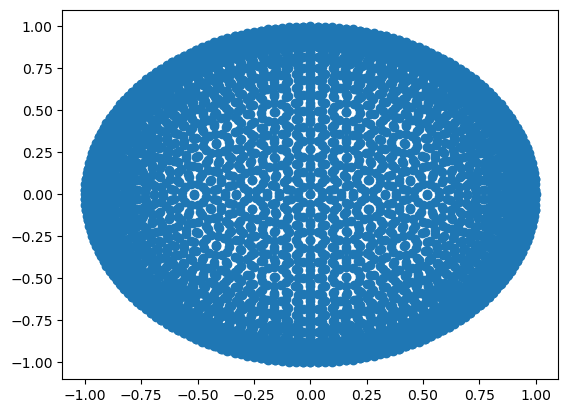

((8000, 3), (8000,), (4002, 3))

In [13]:

# vert = vert.T.copy()-1 #correct for matlab's 1 indexing
# tria = tria.T.copy()
tria = tria.T.copy()-1 #correct for matlab's 1 indexing
vert = vert.T.copy()
use_whiten_mesh=False
if use_whiten_mesh:
    #optionally whiten the mesh
    vert -= np.mean(vert,axis=0)
    vert /= np.std(vert,axis=0).show()
# plt.scatter(x=tria[:,0],y=tria[:,1])
plt.scatter(x=vert[:,0],y=vert[:,2])#,c=rho,cmap='jet')
plt.show()
# vert.shape,tria.shape,rho.shape,np.max(vert)
tria.shape,rho.shape,vert.shape

In [14]:
colors = get_colors_trimesh(rho, plt.cm.jet)


# # if colormap is None:
# colormap = plt.cm.jet
# norm = plt.Normalize(vmin=None, vmax=None)
# colors = colormap(norm(rho))
# # (255*colors/np.max(colors)).astype('uint8')[:,0,:]
# colors = (255*colors/np.max(colors)).astype('uint8')#[:,0:]


In [15]:
# initialize mesh colored by rho
mesh = trimesh.Trimesh(vertices=vert,faces=tria,
                       face_colors=colors,
                       face_attributes={'rho':rho})

In [16]:
# the convex hull is another Trimesh object that is available as a property
# lets compare the volume of our mesh with the volume of its convex hull
print(f"{mesh.volume / mesh.convex_hull.volume=:.7f}")
# # since the mesh is watertight, it means there is a
# # volumetric center of mass which we can set as the origin for our mesh
print(f"{mesh.center_mass=}")
# mesh.vertices -= mesh.center_mass
print(f"{mesh.center_mass=}")
# what's the moment of inertia for the mesh?
print(f"{mesh.moment_inertia=}")

# # if there are multiple bodies in the mesh we can split the mesh by
# # connected components of face adjacency
# # since this example mesh is a single watertight body we get a list of one mesh
# mesh.split()

# axis aligned bounding box is available
print(f"{mesh.bounding_box.extents=}")

mesh.volume / mesh.convex_hull.volume=1.0000000
mesh.center_mass=array([ 0.00000000e+00,  3.53884582e-17, -4.42355728e-18])
mesh.center_mass=array([ 0.00000000e+00,  3.53884582e-17, -4.42355728e-18])
mesh.moment_inertia=array([[ 1.67165441e+00,  1.48029737e-17, -1.29526020e-17],
       [ 1.48029737e-17,  1.67165448e+00,  6.33706986e-08],
       [-1.29526020e-17,  6.33706986e-08,  1.67165430e+00]])
mesh.bounding_box.extents=array([2., 2., 2.])


In [17]:
# # #color vertices manually
# # for i,c in enumerate(vertex_colors):
# #     mesh.visual.vertex_colors[i]=c
# # mesh.visual.vertex_colors
# # #randomize face colors
# for face in mesh.faces:
#     mesh.visual.vertex_colors[face] = colors[face]
# for facet in mesh.facets:
#     mesh.visual.vertex_colors[facet] = trimesh.visual.random_color()
# mesh.show()

In [18]:
# #plot an image on the mesh
# m = mesh
# uv = np.random.rand(m.vertices.shape[0], 2)
# # im = np.random.rand(m.vertices.shape[0], m.vertices.shape[0])
# im = np.random.rand(200,200)
# material = trimesh.visual.texture.SimpleMaterial(image=im)
# color_visuals = trimesh.visual.TextureVisuals(uv=uv, image=im, material=material)
# mesh=trimesh.Trimesh(vertices=m.vertices, faces=m.faces, visual=color_visuals, validate=True, process=False)
# mesh.show()

In [19]:
# # transform method can be passed a (4, 4) matrix and will cleanly apply the transform
# mesh.apply_transform(trimesh.transformations.random_rotation_matrix())

# # a minimum volume oriented bounding box also available
# # primitives are subclasses of Trimesh objects which automatically generate
# # faces and vertices from data stored in the 'primitive' attribute
# print(f"{mesh.bounding_box_oriented.primitive.extents=}")
# print(f"{mesh.bounding_box_oriented.primitive.transform=}")

# # bounding spheres and bounding cylinders of meshes are also
# # available, and will be the minimum volume version of each
# # except in certain degenerate cases, where they will be no worse
# # than a least squares fit version of the primitive.
# print(f"""{mesh.bounding_box_oriented.volume=},
#       {mesh.bounding_cylinder.volume=},
#       {mesh.bounding_sphere.volume=}""")

# # show the mesh appended with its oriented bounding box
# # the bounding box is a trimesh.primitives.Box object, which subclasses
# # Trimesh and lazily evaluates to fill in vertices and faces when requested
# # (press w in viewer to see triangles)
# # (mesh + mesh.bounding_box_oriented).show()
# mesh.show()


In [20]:
#view the mesh
mesh.show()
# scene = trimesh.scene.Scene(mesh)
# trimesh.viewer.notebook.scene_to_notebook(scene=scene, height=200)

In [21]:
#print mesh bluf
print(f"{mesh.volume=}")
print(f"{mesh.center_mass=}")
print(f"{mesh.is_watertight=} (is the current mesh watertight?)")
print(f"{mesh.euler_number=} (what's the euler number for the mesh?)")

mesh.volume=4.182994798204928
mesh.center_mass=array([ 0.00000000e+00,  3.53884582e-17, -4.42355728e-18])
mesh.is_watertight=True (is the current mesh watertight?)
mesh.euler_number=2 (what's the euler number for the mesh?)


In [22]:
volume_initial = mesh.volume#=4.182994798204928
print(f"{volume_initial=} voxels")

volume_initial=4.182994798204928 voxels


# DONE: generate smaller mesh for dev of real eigensolving
- note: this mesh is singular...

In [22]:
# # vert = trimesh.sample.sample_surface_sphere(100)

# radius=1.0
# mesh = trimesh.creation.uv_sphere(
#     radius=radius,
#     count=[5, 5],)
# #     count=[10, 10],)
# #     count=[32, 32],)
# mesh.center_mass

# cscale=5
# #caste discrete unit sphere to numpy
# vert = np.array(mesh.vertices)
# tria = np.array(mesh.faces)
# rho  = tria[:,0]*0.+1./(2.*radius)
# #randomize the target curvatrue
# np.random.seed(42)
# rho *= cscale*np.random.rand(*rho.shape)
# rho.shape

# colors = get_colors_trimesh(rho, plt.cm.jet)
# # colors[colors==0]=1

# # initialize mesh colored by rho
# mesh = trimesh.Trimesh(vertices=vert,faces=tria,
#                        face_colors=colors,
#                        face_attributes={'rho':rho})

# # mesh.show()

# TODO(later, after mvp): dev implementation using numpy-quaternion package
- it is difficult to do this with numpy-quaternion?
- Q: does quaternionic package handle matrix inverses?

In [23]:
# import quaternionic
# import quaternion

In [24]:
# # function V=spin(T,V,rho)
# # % input: T (3xN) and V (3xM) so that
# # %  trimesh(T',V(1,:),V(2,:),V(3,:)) plots the triangular mesh,
# # %  rho (1xN) values of conformal scaling
# # % output: V (3xM) vertices of transformed mesh
# #input: T,V,rho

# T = tria
# V = vert
# #input: T,V,rho
# #output: V or V_out,ome_out

# nT=T.shape[0]
# nV=V.shape[0]
# # plc=list(range(-3,1))
# # plc=np.array(list(range(-3,1)))
# #initialize virtual memory
# # E = scipy.sparse.csc_matrix((4*nV,4*nV), dtype=V.dtype)
# # E = scipy.sparse.csr_matrix((4*nV,4*nV), dtype=V.dtype)
# # E = scipy.sparse.bsr_matrix((4*nV,4*nV), dtype=V.dtype)
# # E = np.zeros((4*nV,4*nV), dtype=V.dtype)
# #Q: which is faster? csr or bsr or csc?
# # E = np.zeros((nV,nV), dtype=V.dtype)
# # E = np.zeros((nV,nV,4), dtype=np.quaternion)
# E = np.zeros((nV,nV), dtype=np.quaternion)

# edg=np.zeros(shape=(3,4))
# # pnty = np.zeros(4)
# pntz = np.zeros(4)
# # ini=np.zeros(shape=(3,4),dtype='int64')
# # ini=np.zeros(shape=(4,3),dtype='int64')
# edgy=np.zeros(shape=(3,4),dtype=V.dtype)
# E.dtype,edg.dtype,pnty,pntz,edgy.shape,edgy.dtype

In [25]:
# for c1 in range(nT):
#     tri = T[c1]
#     pnt=V[tri]
#     #compute triangle area
#     A = 0.5*np.linalg.norm(np.cross(pnt[1]-pnt[0], pnt[2]-pnt[0]))
#     a = -0.25/A  # a=-1/(4*A)
#     #compute target curvature component
#     r = rho[c1]
#     b = r/6. #  b=rho(c1)/6;
#     # pnty[0]=A*r**2/9.
#     # c = jiH(pnty) #c=jiH([A*rho(c1)*rho(c1)/9 0 0 0]);
#     # c = np.quaternion(pnty)
#     c = np.quaternion(A*r**2/9.)
#     for c2 in range(3):
#         #Q: is this value right?
#         # V[tri[(c2+1)%3+1]] - V[tri[(c2+0)%3+1]]
#         pntz[1:] = V[tri[(c2+1)%3]] - V[tri[(c2+0)%3]]
#         edg[c2]  = pntz.copy()
#         # edg[c2]  = [0;V(:, tri(mod(c2+1,3)+1) )-V(:, tri(mod(c2+0,3)+1) )]
#     wooo = np.array([[
#         np.quaternion(*(a*jiH(edg[0])@edg[0]))+c, 
#         np.quaternion(*(a*jiH(edg[0])@edg[1]  + b*(edg[1]-edg[0])))+c, 
#         np.quaternion(*(a*jiH(edg[0])@edg[2]  + b*(edg[2]-edg[0])))+c], [
#         np.quaternion(*(a*jiH(edg[1])@edg[0]  + b*(edg[0]-edg[1])))+c, 
#         np.quaternion(*(a*jiH(edg[1])@edg[1]))+c,
#         np.quaternion(*(a*jiH(edg[1])@edg[2]  + b*(edg[2]-edg[1])))+c], [
#         np.quaternion(*(a*jiH(edg[2])@edg[0]  + b*(edg[0]-edg[2])))+c, 
#         np.quaternion(*(a*jiH(edg[2])@edg[1]  + b*(edg[1]-edg[2])))+c, 
#         np.quaternion(*(a*jiH(edg[2])@edg[2]))+c
#     ]])
#     E[np.ix_(tri,tri)] = E[np.ix_(tri,tri)] + wooo

In [26]:
# q^{-1}=q'/(q*q')


In [27]:
# (E.T*E)

In [28]:
# quaternion.quaternion.

In [29]:
# quaternion.quaternion_time_series.
# quaternion.means?

In [30]:
# # quaternion.quaternion.inverse(E)
# (quaternion.as_spinor_array(np.quaternion(1,0,0,0)),
#     quaternion.as_spinor_array(np.quaternion(0,1,0,0)),
#     quaternion.as_spinor_array(np.quaternion(0,0,1,0)),
#     quaternion.as_spinor_array(np.quaternion(0,0,0,1)))

In [31]:
#TODO: get the real case working...
#TODO: map float array to nV*2xnV*2 complex array and take the eigen decomposition.
# quaternion.as_float_array(E)

In [32]:
# E.astype(np.complex64)

In [33]:
# quaternion.as_spinor_array(E).shape

In [34]:
# np.linalg.inv(quaternion.as_spinor_array(E))

In [35]:
# (E/E).shape

In [36]:
# #Q: does this work as a fast matrix inverse?
# q_identity = E/E
# boon=np.isnan(q_identity)
# q_identity[boon]=0*E[boon]
# q_identity[0][:3]

In [37]:
# # boo_nan = np.isnan(q_identity[0][3:])
# boo_nan = np.isnan(q_identity[100])
# np.argwhere(boo_nan).all()

In [38]:
# lam=np.zeros(nV,dtype=np.quaternion)+1
# # lam=zeros(4*nV,1);
# # lam(1:4:end)=1;  
# lam.shape

In [39]:
# for c1 in range(11):
#     pass

# cnv=lam
# lam=lam/E
# lam.shape

In [40]:
# boon=np.isnan(lam)
# boon.shape

In [41]:
# q_identity[boon]=0*E[boon]

In [42]:

# lam=lam/np.norm(lam)

In [43]:
# for c1=1:11
#   cnv=lam;
#   lam=E\lam;
#   lam=lam/norm(lam);
# end

In [44]:


# res=(E*lam)./lam;  
# fprintf('mean %e, var %e, delta %e\n',mean(res),var(res),norm(cnv-lam))


In [45]:

# L  =sparse(4*nV,4*nV);
# ome=zeros(4*nV,1);
# for c1=1:nT
#   for c2=1:3
#     k0=T(mod(c2-1,3)+1,c1);
#     k1=T(mod(c2+0,3)+1,c1);
#     k2=T(mod(c2+1,3)+1,c1);
#     u1=V(:,k1)-V(:,k0);
#     u2=V(:,k2)-V(:,k0);
#     cta=dot(u1,u2) / norm( cross(u1,u2) );
#     h=jiH([cta*0.5 0 0 0]);
#     ini=[k1*4+plc  k2*4+plc];
#     L(ini,ini)=L(ini,ini)+[ h -h;-h h];
#     if k1>k2
#       k3=k1; k1=k2; k2=k3; % swap
#     end
#     lm1=jiH(lam(k1*4+plc));
#     lm2=jiH(lam(k2*4+plc));
#     edv=jiH([0;V(:,k2)-V(:,k1)]);
#     til=lm1'*edv*lm1/3 + lm1'*edv*lm2/6 + lm2'*edv*lm1/6 + lm2'*edv*lm2/3;
#     ome(k1*4+plc,1)=ome(k1*4+plc,1)-cta*til(:,1)/2;
#     ome(k2*4+plc,1)=ome(k2*4+plc,1)+cta*til(:,1)/2;
#   end
#   if ~mod(c1,500); fprintf('.'); end
# end
# fprintf('\n')

# ome=reshape(ome,[4 nV]);
# ome=ome-repmat(mean(ome,2),[1 nV]);
# ome=reshape(ome,[4*nV 1]);
# ome=L\ome;
# ome=reshape(ome,[4 nV]);
# ome=ome-repmat(mean(ome,2),[1 nV]);
# nrm=sum(ome.*ome,1);
# ome=ome/sqrt(max(nrm));
# V=ome(2:end,:);


In [46]:
# # import numpy-quaternion
# !conda install -c conda-forge quaternion

In [47]:
# # function h=jiH(pnt)
# # a=pnt(1); b=pnt(2); c=pnt(3); d=pnt(4);
# # h=[ a -b -c -d
# #     b  a -d  c
# #     c  d  a -b
# #     d -c  b  a];

# # @np.vectorize
# @njit
# def jiH(pnt):
#     """jiH castes a cartesion point, pnt, to a real quaternionic representation."""
#     a=pnt[0]; b=pnt[1]; c=pnt[2]; d=pnt[3];
#     h = np.array([
#         [a, -b, -c, -d],
#         [b,  a, -d,  c],
#         [c,  d,  a, -b],
#         [d, -c,  b,  a]])
#     return h

# # @njit
# # def jiH_vectorized(pnt_array):
# #     """jiH_vectorized complexifies an array of quaterions.
    
# #     Example Usage:
# # jiH_vectorized(a*jiH(edg[0]*edg[0]))
# #     """
# #     #h = np.array([jiH(x) for x in pnt_array]) #numba does not support this it seems...
# #     num = pnt_array.shape[0]
# #     h=np.empty(shape=(num,4,4))
# #     for i in range(num):
# #         h[i]=jiH(pnt_array[i])
# #     return h
    

In [48]:
# #test jiH runs reasonably fast
# arr = np.reshape([0,1,2,3]*300,(300,4))
# a_lst=[]
# for pnt in arr:
#     a = jiH(pnt)
#     a_lst.append(a)
# #test jiH_vectorized runs reasonably fast
# # jiH_vectorized(np.concatenate(a_lst)).shape

# Step 1) DONE: represent the deformation as a matrix of real quaternions

In [162]:
#heretim 
#def deform_mesh_conformally_real_simple(T,V,rho):
T = tria
V = vert
V.shape,V.dtype,rho.dtype

((4002, 3), dtype('float64'), dtype('float64'))

In [163]:
tria.shape,vert.shape,rho.shape,np.max(rho)

((8000, 3), (4002, 3), (8000,), 3.1789758729936084)

In [25]:
####################################
# Generate the Ensemble Matrix (E)
####################################
# function V=spin(T,V,rho)
# % input: T (3xN) and V (3xM) so that
# %  trimesh(T',V(1,:),V(2,:),V(3,:)) plots the triangular mesh,
# %  rho (1xN) values of conformal scaling
# % output: V (3xM) vertices of transformed mesh
#input: T,V,rho
#output: E
printing=True
nT=T.shape[0]
nV=V.shape[0]
# plc=list(range(-3,1))
plc=np.array(list(range(-3,1)))
step=0
num_steps=nT-1
update_printbar_every=int(np.around(nT/20))
#initialize virtual memory
# E = scipy.sparse.csc_matrix((4*nV,4*nV), dtype=V.dtype)
# E = scipy.sparse.csr_matrix((4*nV,4*nV), dtype=V.dtype)
# E = scipy.sparse.bsr_matrix((4*nV,4*nV), dtype=V.dtype)
E = np.zeros((4*nV,4*nV), dtype=V.dtype)
#Q: which is faster? csr or bsr or csc? I can caste to dense for solveh_banded later
edg=np.zeros(shape=(3,4))
pnty = np.zeros(4)
pntz = np.zeros(4)
ini=np.zeros(shape=(3,4),dtype=tria.dtype)
ini=np.zeros(shape=(3,4),dtype='int64')
# ini=np.zeros(shape=(4,3),dtype='int64')
# edgy=np.zeros(shape=(3,4),dtype=V.dtype)
# E.dtype,edg.dtype,pnty,pntz,edgy.shape,edgy.dtype

# for c1 in range(-1,nT):
# for c1 in range(1,nT):
for c1 in range(nT):
    tri = T[c1]
    pnt=V[tri]
    #pnt=V[tri].T #nope. 
    #compute triangle area
    A = 0.5*np.linalg.norm(np.cross(pnt[1]-pnt[0], pnt[2]-pnt[0]))
    a = -0.25/A  # a=-1/(4*A)
    #compute target curvature component
    r = rho[c1]
    b = r/6. #  b=rho[c1]/6;
    pnty[0]=A*r**2/9.
    c = jiH(pnty) #c=jiH([A*rho[c1]*rho[c1]/9 0 0 0]);

    for c2 in range(3):
#     for c2 in range(1,4):
        #Q: is this value right?
        # V[tri[(c2+1)%3+1]] - V[tri[(c2+0)%3+1]]
#         pntz[1:] = V[tri[(c2+1)%3]] - V[tri[(c2+0)%3]]
        pntz[1:] = V[tri[(c2+1)%3]] - V[tri[(c2+0)%3]]
        #pntz[1:] = -V[tri[(c2+1)%3]] + V[tri[(c2+0)%3]]
        #pntz[1:] = V[tri[(c2)%3]] - V[tri[(c2-1)%3]]
#         edg[(c2-2)%3]  = pntz.copy()
        edg[(c2-1)%3]  = pntz.copy()
#         edg[c2]  = pntz.copy()
#         edg[(c2+1)%3]  = pntz.copy()
        # edg[c2]  = [0;V(:, tri(mod(c2+1,3)+1) )-V(:, tri(mod(c2+0,3)+1) )]

    # signature of ini: 0ijk of triangle vertex 1,2,3
    # pseudo-signature of ini: vertex index as axis 0 & quaternion index as axis 1
    # signature of wooo: vertex index as axis 0,1 & quaternion index as axis 2,3
    #result: in matlab, 
    # E(ini,ini) indexes from the 0ijk fields of each triangle vertex 
    # to the 0ijk fields of each triangle vertex of that same triangle.
    ini[0] = tri[0]*4+plc
    ini[1] = tri[1]*4+plc
    ini[2] = tri[2]*4+plc 
#     ini[0] = (tri[0]+1)*4+plc 
#     ini[1] = (tri[1]+1)*4+plc
#     ini[2] = (tri[2]+1)*4+plc
    # ini=np.array([tri[0]*4+plc, tri[1]*4+plc, tri[2]*4+plc])
    # ini=[tri(1)*4+plc tri(2)*4+plc tri(3)*4+plc];
    # wo1 = np.array((jiH(a*jiH(edg[0])@edg[0])+c, 
    #     jiH(a*jiH(edg[0])@edg[1]  + b*(edg[1]-edg[0]))+c, 
    #     jiH(a*jiH(edg[0])@edg[2]  + b*(edg[2]-edg[0]))+c))
    # wo1.shape #(3, 4, 4)
    # wo2 = np.array((jiH(a*jiH(edg[1])@edg[0]  + b*(edg[0]-edg[1]))+c, 
    #     jiH(a*jiH(edg[1])@edg[1])+c,
    #     jiH(a*jiH(edg[1])@edg[2]  + b*(edg[2]-edg[1]))+c))
    # wo2.shape #(3, 4, 4)
    # wo3 = np.array((jiH(a*jiH(edg[2])@edg[0]  + b*(edg[0]-edg[2]))+c, 
    #     jiH(a*jiH(edg[2])@edg[1]  + b*(edg[1]-edg[2]))+c, 
    #     jiH(a*jiH(edg[2])@edg[2])+c))
    # wo3.shape #(3, 4, 4)
    # Q: does casting E to a sparse bsc matrix speed up any expensive linear algebra operations?
    wooo = np.array([[
        jiH(a*jiH(edg[0])@edg[0])+c, 
        jiH(a*jiH(edg[0])@edg[1]  + b*(edg[1]-edg[0]))+c, 
        jiH(a*jiH(edg[0])@edg[2]  + b*(edg[2]-edg[0]))+c], 
        [jiH(a*jiH(edg[1])@edg[0] + b*(edg[0]-edg[1]))+c, 
        jiH(a*jiH(edg[1])@edg[1])+c,
        jiH(a*jiH(edg[1])@edg[2]  + b*(edg[2]-edg[1]))+c], 
        [jiH(a*jiH(edg[2])@edg[0] + b*(edg[0]-edg[2]))+c, 
        jiH(a*jiH(edg[2])@edg[1]  + b*(edg[1]-edg[2]))+c, 
        jiH(a*jiH(edg[2])@edg[2])+c] 
    ])
#     wooo = np.array([[
#         jiH(a*jiH(edg[0])@edg[0])+c, 
#         jiH(a*jiH(edg[0])@edg[1]  + b*(edg[1]-edg[0]))+c, 
#         jiH(a*jiH(edg[0])@edg[2]  + b*(edg[2]-edg[0]))+c], 
#         [jiH(a*jiH(edg[1])@edg[0] + b*(edg[0]-edg[1]))+c, 
#         jiH(a*jiH(edg[1])@edg[1])+c,
#         jiH(a*jiH(edg[1])@edg[2]  + b*(edg[2]-edg[1]))+c], 
#         [jiH(a*jiH(edg[2])@edg[0] + b*(edg[0]-edg[2]))+c, 
#         jiH(a*jiH(edg[2])@edg[1]  + b*(edg[1]-edg[2]))+c, 
#         jiH(a*jiH(edg[2])@edg[2])+c] 
#     ])
#     ])
#Q: does transposing the output of jiH everywhere make the update to E agree with demo?
# #A: nope.?
#     wooo = np.array([[
#         jiH(a*jiH(edg[0]).T@edg[0])+c, 
#         jiH(a*jiH(edg[0]).T@edg[1]  + b*(edg[1]-edg[0]))+c, 
#         jiH(a*jiH(edg[0]).T@edg[2]  + b*(edg[2]-edg[0]))+c], 
#         [jiH(a*jiH(edg[1]).T@edg[0] + b*(edg[0]-edg[1]))+c, 
#         jiH(a*jiH(edg[1]).T@edg[1])+c,
#         jiH(a*jiH(edg[1]).T@edg[2]  + b*(edg[2]-edg[1]))+c], 
#         [jiH(a*jiH(edg[2]).T@edg[0] + b*(edg[0]-edg[2]))+c, 
#         jiH(a*jiH(edg[2]).T@edg[1]  + b*(edg[1]-edg[2]))+c, 
#         jiH(a*jiH(edg[2]).T@edg[2])+c] 
#     ])
    #woooo = wooo.reshape((12, 12))
#     #is ^this mucking it up?
# # #     wooo_= np.concatenate([wooo[2],wooo[1],wooo[0]],axis=1)
# # #     woooo = np.hstack([wooo_[2],wooo_[1],wooo_[0]])
# # #     wooo_= np.concatenate([wooo[2],wooo[0],wooo[1]],axis=1)
# # #     woooo = np.hstack([wooo_[2],wooo_[0],wooo_[1]])
#     wooo_= np.concatenate([wooo[1],wooo[2],wooo[0]],axis=1)
#     woooo = np.hstack([wooo_[1],wooo_[2],wooo_[0]])

#     #DONE: find the correct reshaping snippet
#     #reshape to square matrix local vertex representation
#     wooo_= np.concatenate([wooo[0],wooo[1],wooo[2]],axis=1)
#     woooo = np.hstack([wooo_[0],wooo_[1],wooo_[2]])
#     wooo_= np.concatenate([wooo[0],wooo[1],wooo[2]],axis=2)
#     woooo = np.vstack([wooo_[0],wooo_[1],wooo_[2]])
#     woooo=np.hstack([
#         np.concatenate([wooo[0,0], wooo[0,1], wooo[0,2]]),
#         np.concatenate([wooo[1,0], wooo[1,1], wooo[1,2]]),
#         np.concatenate([wooo[2,0], wooo[2,1], wooo[2,2]])])

#     woooo=np.hstack([
#         np.concatenate([wooo[0,0].T, wooo[0,1].T, wooo[0,2].T]),
#         np.concatenate([wooo[1,0].T, wooo[1,1].T, wooo[1,2].T]),
#         np.concatenate([wooo[2,0].T, wooo[2,1].T, wooo[2,2].T])]).T
#     woooo=np.hstack([
#         np.concatenate([wooo[0,0].T, wooo[1,0].T, wooo[2,0].T]),
#         np.concatenate([wooo[0,1].T, wooo[1,1].T, wooo[2,1].T]),
#         np.concatenate([wooo[0,2].T, wooo[1,2].T, wooo[2,2].T])]).T
    #reshape to square matrix local vertex representation
    woooo=np.hstack([
        np.concatenate([wooo[0,0], wooo[1,0], wooo[2,0]]),
        np.concatenate([wooo[0,1], wooo[1,1], wooo[2,1]]),
        np.concatenate([wooo[0,2], wooo[1,2], wooo[2,2]])]).T
    
#perturbing of ibid
#     woooo=np.hstack([
#         np.concatenate([wooo[0,0], wooo[1,0], wooo[2,1]]),
#         np.concatenate([wooo[0,1], wooo[1,1], wooo[2,0]]),
#         np.concatenate([wooo[1,2], wooo[0,2], wooo[2,2]])]).T

    
#     woooo=np.hstack([
#         np.concatenate([wooo[0,0].T, wooo[1,0].T, wooo[2,0].T]),
#         np.concatenate([wooo[0,1].T, wooo[1,1].T, wooo[2,1].T]),
#         np.concatenate([wooo[0,2].T, wooo[1,2].T, wooo[2,2].T])])

#     woooo=np.hstack([
#         np.concatenate([wooo[0,0], wooo[1,0], wooo[2,0]]),
#         np.concatenate([wooo[0,1], wooo[1,1], wooo[2,1]]),
#         np.concatenate([wooo[0,2], wooo[1,2], wooo[2,2]]),
#     ])
#obviously wrong
#     woooo=np.hstack([
#         np.concatenate([wooo[0,0].T, wooo[0,1].T, wooo[0,2].T]),
#         np.concatenate([wooo[1,0], wooo[1,1].T, wooo[1,2].T]),
#         np.concatenate([wooo[2,0], wooo[2,1], wooo[2,2].T])]).T

#     wooo_= np.concatenate([wooo[1],wooo[2],wooo[0]],axis=2)
#     woooo = np.vstack([wooo_[1],wooo_[2],wooo_[0]])
#     wooo_= np.concatenate([wooo[2],wooo[1],wooo[0]],axis=2)
#     woooo = np.vstack([wooo_[2],wooo_[1],wooo_[0]])
    #write to global vertex representation
    inii=ini.flatten()
    E[np.ix_(inii, inii)] += woooo
    #print progress bar
    if printing:
        step+=1
        if step%update_printbar_every==0:
            printProgressBar(step+1, num_steps, prefix = 'Progress:', suffix = 'Complete', length = 50)

In [164]:
np.trace(E),E.dtype

(56100.377239701826, dtype('float64'))

In [187]:
print(np.around(E[np.ix_(inii, inii)],2))
# print(np.around(E[np.ix_(inii, inii)],3))
#DONE: try transposing the offdiagonal entries as they are written to E
# [[ 3.55  0.    0.    0.   -0.72 -0.07 -0.01  0.01 -0.33 -0.02 -0.06  0.02]
#  [ 0.    3.55  0.   -0.    0.07 -0.72  0.01  0.01  0.02 -0.33  0.02  0.06]
#  [-0.   -0.    3.55  0.    0.01 -0.01 -0.72 -0.07  0.06 -0.02 -0.33 -0.02]
#  [-0.    0.    0.    3.55 -0.01 -0.01  0.07 -0.72 
#DONE: make E(ini,ini) match the matlab demo exactly.


[[ 3.55 -0.   -0.    0.   -0.72  0.03 -0.01  0.   -0.72  0.04  0.01 -0.  ]
 [ 0.    3.55  0.    0.   -0.03 -0.72  0.    0.01 -0.04 -0.72 -0.   -0.01]
 [ 0.   -0.    3.55 -0.    0.01 -0.   -0.72  0.03 -0.01  0.   -0.72  0.04]
 [-0.   -0.    0.    3.55 -0.   -0.01 -0.03 -0.72  0.    0.01 -0.04 -0.72]
 [-0.72 -0.03  0.01 -0.    3.55  0.    0.    0.   -0.33  0.    0.03 -0.02]
 [ 0.03 -0.72 -0.   -0.01 -0.    3.55  0.    0.   -0.   -0.33 -0.02 -0.03]
 [-0.01  0.   -0.72 -0.03  0.   -0.    3.55  0.   -0.03  0.02 -0.33  0.  ]
 [ 0.    0.01  0.03 -0.72 -0.    0.   -0.    3.55  0.02  0.03 -0.   -0.33]
 [-0.72 -0.04 -0.01  0.   -0.33 -0.   -0.03  0.02  3.55  0.    0.    0.  ]
 [ 0.04 -0.72  0.    0.01  0.   -0.33  0.02  0.03 -0.    3.55  0.   -0.  ]
 [ 0.01 -0.   -0.72 -0.04  0.03 -0.02 -0.33 -0.   -0.   -0.    3.55  0.  ]
 [-0.   -0.01  0.04 -0.72 -0.02 -0.03  0.   -0.33 -0.    0.   -0.    3.55]]


- ROOT CAUSE OF L DISAGREEMENT IDENTIFIED: E DISAGREES. 
- ROOT CAUSE RESOLVED.  it appears so, yes.
- DONE: verified all the entries of E agree in sign and magnitude

In [188]:
# print(np.around(woooo,2))
# print(np.around(E[:9,:9],2))
print(np.around(E[1:6,1:6],2))
# print(np.around(E[1:10,1:10],2))

[[ 3.56 -0.   -0.   -0.   -0.33]
 [ 0.    3.56 -0.    0.    0.04]
 [ 0.    0.    3.56 -0.   -0.  ]
 [ 0.   -0.    0.    3.56  0.05]
 [-0.33  0.04 -0.    0.05  3.56]]


In [189]:
print(np.around(E[-9:,-9:],2))

[[ 3.55 -0.    0.01 -0.   -0.72  0.03  0.    0.    0.  ]
 [ 0.    3.55 -0.   -0.01 -0.03 -0.72  0.    0.    0.  ]
 [ 0.01 -0.    3.55 -0.   -0.    0.    0.    0.    0.  ]
 [-0.   -0.01  0.    3.55  0.    0.    0.    0.    0.  ]
 [-0.72 -0.03  0.   -0.    3.55 -0.    0.    0.    0.  ]
 [ 0.03 -0.72 -0.   -0.    0.    3.55  0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    3.64  0.   -0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    3.64  0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    3.64]]


In [30]:
# E_csc = scipy.sparse.csc_matrix(E)
# # #>3.5 minute runtime
# Einv_csc = scipy.sparse.linalg.inv(E_csc)
# Einv_ = Einv_csc.todense()

# E_bsr = scipy.sparse.bsr_matrix(E)
# # #3.5 min runtime
# Einv_bsr = scipy.sparse.linalg.inv(E_bsr)
##  SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
#Einv_ = Einv_bsr.todense()

# #DONE: checked block inverse equals inverse to 13 significant digits
# np.max(Einv_-Einv)

percent of matrix elements that are nonzero: 0.1562%


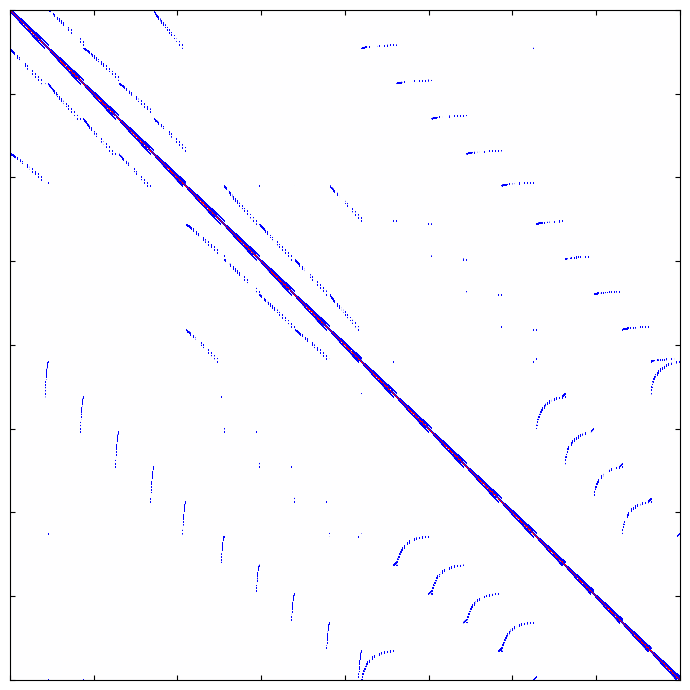

In [31]:
#plot E as a heatmap
# atol=1e-1
# atol=1e-3
atol=1e-5
# atol=1e-10
atol=1e-13
vmax=np.max((-np.min(E),np.max(E)))
vmax=-np.min(E)
# vmax=-np.min(E)/1000
boo=np.isclose(E,0.,atol=atol)
frac_nonzero = (~boo).sum()/np.sum(boo)
print(f"percent of matrix elements that are nonzero: {frac_nonzero:.4%}")

# vmax=0.01
# vmax=0.001
vmax=0.0001
figsize=(4,4)
# figsize=(7,7)
fig,ax=plt.subplots(figsize=(7,7))
ax.imshow(E,
    cmap='bwr',
# #     norm=None,
# #     aspect=None,
# #     interpolation=None,
# #     alpha=None,
    vmin=-vmax,
    vmax=vmax)
# format_plot
# format_plot(ax=ax,xlabel=r'n (1/cm$^2$)',ylabel=r'w (Hz/cm$^2$)',fontsize=fontsize)#,use_loglog=True)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(top=True, right=True,direction='in',which='both')
plt.tight_layout()
plt.show()

In [34]:
#test that E is symmetric #~6 second run time
assert np.isclose(E.T,E,5).all()
printing=True

In [166]:
#sparse soln: <20 second run time 
lam,cnv = comp_groundstate_eigenvector_sparse(E)
res=(lam@E)/lam; 
print(f'mean: {np.mean(res):e}, var:  {np.var(res):e}, delta: {np.linalg.norm(cnv-lam):e}')
# mean: -1.825385e-04, var:  1.688050e-04, delta: 2.156203e+05
# Q: how does lam look?
# A: great! 
#banded soln: ?? second run time.... does it crash the kernel?
# mean: ??
# Q: how does lam look?


mean: -1.825385e-04, var:  1.688050e-04, delta: 1.161208e+07


In [ ]:
# # Eab = decomp_banded_matrix(E)
# E_sparse=scipy.sparse.csc_matrix(E,dtype=float)
# lam=np.zeros(4*nV)
# lam[::4]=1.
# b=lam
# # num_steps=11
# # for step in range(num_steps):
# #     cnv=lam
# #Q: what's the fastest way to compute x vs. x2 or x3
# x2 =scipy.sparse.linalg.lsqr(E_sparse,b)[0] #lam=lam/E
# # x3 =solveh_banded(Eab,b)#,lower=False)#,**kwargs) #lam =mldivide(lam,ab)
# #Q: what's the fastest way to compute x vs. x2 or x3
# # A: x2
# lam=x2.copy()
# # lam=x3.copy()

In [173]:
use_inverse_method=False
if use_inverse_method:
    #Warning: 3 minute runtime for 11 epochs
    lam,cnv,Einv = comp_groundstate_eigenvector_inverse(E)
    res=(lam@E)/lam; 
    print(f'mean: {np.mean(res):e}, var:  {np.var(res):e}, delta: {np.linalg.norm(cnv-lam):e}')

In [174]:
# Q: is Einv really needed?
# A: no.

# TODO(later): dev linear interpolating map

for $t\in[0,1]$, we may linearly interpolate a conformal map, $L_p$, according to
$$
L^*(t) = tL_p + (1-t)I_p
$$
where $I_p$ is the trivial identity transformation.

In [199]:
#TODO: dev identity map in Lp representation, Ip

## scratchwerk

In [ ]:
# #>4.5 minute runtime
# Einv=scipy.linalg.inv(E)

In [175]:
# #~2 minute runtime
# Einv=np.linalg.inv(E)

In [43]:
# #>7 minute runtime
# Einvp=np.linalg.pinv(E, rcond=1e-15, hermitian=True)

# #probably also >7 minute runtime
# Einvp=np.linalg.pinv(E, rcond=1e-15, hermitian=False)
# #heretim
# # Q: which matrix inversion methods work?
# # Q: of them, which are fastest?
# 16*11/60

2.933333333333333

In [61]:
np.mean(np.abs(Lp))

0.0

In [176]:
# # ME=Einv_.copy()
# # ME=Einv.copy()
# ME=Lp.copy()
# # ME=Linv.copy() #<<<> not a useful quantity
# # vmax=1
# # vmax=0.00000000000001
# vmax=0.0001
# figsize=(4,4)
# # figsize=(7,7)
# fig,ax=plt.subplots(figsize=(7,7))
# print(f"{vmax=}")
# ax.imshow(ME,
#     cmap='bwr',
# # #     norm=None,
# # #     aspect=None,
# # #     interpolation=None,
# # #     alpha=None,
#     vmin=-vmax,
#     vmax=vmax)
# # format_plot
# ax.set_xticklabels([])
# ax.set_yticklabels([])
# ax.tick_params(top=True, right=True,direction='in',which='both')
# plt.tight_layout()
# plt.show()

In [ ]:
# Einv__ = scipy.linalg.pinvh(E) #<<<crashed the kernel...
# print(np.allclose(a, a @ B @ a))
# print(np.allclose(B, B @ a @ B))

In [ ]:
#heretimheretim
# np.linalg.invh

In [ ]:
# 1

In [ ]:
# # Einv
# Einv=np.outer(y,y)
# Einv.shape

In [ ]:
# #2 min runtime
# #NOTE: it took 1.5 - 2 minutes to invert E in the real representation for the demo
# Einv = np.linalg.inv(E)

In [178]:
# # Einv.shape
# #test the inverted matrix has only valid entries
# assert not np.isnan(Einv).any()
# assert not np.isinf(Einv).any()

In [ ]:
# #~2 minute runtime
# #test the inverse matrix works with left multiplication
# roo = np.abs( (Einv@E) - np.eye(E.shape[0]))
# print(roo[:3,:3])
# print(np.min(roo),np.max(roo)) #13 sig figs of agreement
# # [[3.78586051e-14 1.76031711e-14 1.90380781e-14]
# #  [1.00960100e-15 4.44089210e-16 8.99237282e-16]
# #  [1.76510237e-14 4.79217360e-17 4.44089210e-16]]
# # (0.0, 2.656980762521612e-13)

# #test the inverse matrix works with right multiplication
# roo = np.abs( (E@Einv) - np.eye(E.shape[0]))
# print(roo[:3,:3])
# print(np.min(roo),np.max(roo)) #14 sig figs of agreement

# # [[2.22044605e-16 8.06007486e-21 4.38189731e-19]
# #  [4.90931521e-18 2.22044605e-16 1.08420217e-18]
# #  [3.81132037e-18 2.16840434e-19 0.00000000e+00]]
# # (0.0, 1.4262223312566984e-14)

In [ ]:
# Q: should inverse be right multiplied or left multiplied everywhere?
# A: doesn't seem to matter up to a transpose.?

In [ ]:
# y=invh_banded(A=E,x=np.ones(E.shape[0]))
# y=invh_banded(A=E,x=np.zeros(E.shape[0]))

In [ ]:
# #>4 minute runtime
# wb,vb=scipy.linalg.eig_banded(ab)#, lower=False, eigvals_only=False, overwrite_a_band=False, select='a', select_range=None, max_ev=0, check_finite=True)

__Inverting E via LU Decomposition works, but it is not clearly going to be faster (it's $O(N^2)$)__

$$E = P L U$$

where $P$ is a permutation matrix, $L$ lower triangular with unit diagonal elements, and $U$ upper triangular.

In [ ]:
# #<4 minute runtime
# A=E.copy()
# # from scipy.linalg import lu
# p,l,u = scipy.linalg.lu(A, permute_l = False)

# l = np.dot(p,l) 

# l,u = scipy.linalg.lu(A, permute_l = True)

# l_inv = np.linalg.inv(l)

# u_inv = np.linalg.inv(u)

# A_inv = np.dot(u_inv,l_inv)

# # plt.plot(u_inv)
# # plt.plot(l_inv)

# # Q: can I use scipy.linalg.solveh_banded to furth speedup the leastsquare solve?  It's already <30 seconds...
#A: it appears <100ms per solve. let's gooo...! 
# Einv_=A_inv

# # np.dot(Einv_,E)
# eye=Einv_@E
# eye[:5,:5]

In [ ]:
# Fast method would be the Gauss-Jordan method

In [ ]:
# a = np.array([[1,2,0,0], [-1,2,1,0], [0,1,3,1], [0,0,1,2]])
# x = np.array([1,2,3,4])
# b = np.dot(a,x)
# ab = np.empty((3,4))
# ab[0,1:] = np.diag(a,1)
# ab[1,:] = np.diag(a,0)
# ab[2,:-1] = np.diag(a,-1) 
# yy =  scipy.linalg.solve_banded((1,1),ab,b)
# print (yy)

In [ ]:
# Einv
# Q: can i use lu decomp to estimate Einv?

In [ ]:
# Einv_=np.outer(y,y)#nope
# Einv_=np.outer(y.T,y)#nope
# Einv_=np.outer(y,y.T)#nope
# Einv_.shape,E.shape

In [ ]:
# plt.plot(y)

In [ ]:
# #heretim
# # vmax=0.01
# # vmax=0.001
# vmax=0.0001
# figsize=(4,4)
# # figsize=(7,7)
# fig,ax=plt.subplots(figsize=(7,7))
# ax.imshow(Einv,
#     cmap='bwr',
# # #     norm=None,
# # #     aspect=None,
# # #     interpolation=None,
# # #     alpha=None,
#     vmin=-vmax,
#     vmax=vmax)
# # format_plot
# # format_plot(ax=ax,xlabel=r'n (1/cm$^2$)',ylabel=r'w (Hz/cm$^2$)',fontsize=fontsize)#,use_loglog=True)
# ax.set_xticklabels([])
# ax.set_yticklabels([])
# ax.tick_params(top=True, right=True,direction='in',which='both')
# plt.tight_layout()
# plt.show()

In [ ]:
# #warning: these pythonic eigensolvers give different answers for the basic test case...
# # >>> don't assume hermiticity! return to the canned eigen pseudosolver!
# # >>> caution! i could be casting this into a real representation incorrectly!
# #warning: #>16 minutes run time
# #53-37 = >16 
# w, v = np.linalg.eig(E)
# w.shape,v.shape,np.min(w),np.max(w) 
# #for simplest unit sphere example:
# # ((264,),
# #  (264, 264),
# #  (-6.216318184123621-3.508736056987371j),
# #  (10.372886477259154+0j))

# #warning >7 minutes run time
# wh, vh = np.linalg.eigh(E)
# wh.shape,vh.shape,np.min(wh),np.max(wh)
# #for simplest unit sphere example:
# # ((264,), (264, 264), -13.124313869577566, 12.598788742101325)

In [ ]:
# E_bsr = scipy.sparse.bsr_matrix(E)#, dtype=V.dtype)
# E_bsr


# #4 min runtime
# Einv_bsr = scipy.sparse.linalg.inv(E_bsr)

# E_csc = scipy.sparse.csc_matrix(E)#, dtype=V.dtype)

# #>2 minute runtime
# Einv_csc = scipy.sparse.linalg.inv(E_csc)

In [ ]:
# # vals, vecs = scipy.sparse.linalg.eigs(E_bsr, k=6)
# vals, vecs = scipy.sparse.linalg.eigs(E_bsr, k=30)
# print(*vals)
# vals.shape, vecs.shape

In [ ]:
# E_bsr = scipy.sparse.bsr_matrix(E)#, dtype=V.dtype)
# E_bsr
# # vals, vecs = scipy.sparse.linalg.eigs(E_bsr, k=6)
# vals, vecs = scipy.sparse.linalg.eigs(E_bsr, k=30)
# print(*vals)
# vals.shape, vecs.shape

In [179]:
# print(np.min(E),np.max(E))
# print(np.min(Einv),np.max(Einv))
# # -0.7250259143115632 3.5552214831079576
# # -1.3519086938558618 2.7442374749979765

In [180]:
#input: Einv,V,T
#output: ome

In [181]:
# #input: Einv
# #output: lam approximating the groundstate eigenvector
# lam=np.zeros(4*nV)
# # lam[1::4]=1.
# # lam[-1::4]=1.
# # lam[::4]=1.
# lam[3::4]=1.
# lam/=np.linalg.norm(lam)
# # lam+=1.
# #Q: is ^this right?
# #Q is this better? lam[3::4]=1.
# ## lam(1:4:end)=1;  
# print(lam.shape)
# # for c1 in range(11):
# # for c1 in range(111):
# # for c1 in range(11):
# # for c1 in range(12):
# for c1 in range(11):
#     cnv=lam
#     #lam=lam/E
#     lam =lam@Einv
# #     lam =Einv@lam
#     #Q: left multiply instead or right multiply?
#     #heretim
#     lam/=np.linalg.norm(lam);
# print(lam.shape)
# # np.min(lam),np.max(lam)
# # res=(E@lam)/lam; 
# res=(lam@E)/lam; 
# # print(f'mean: {np.mean(res):.4f}, var:  {np.var(res):.4f}, delta: {np.linalg.norm(cnv-lam):.4f}')
# print(f'mean: {np.mean(res):e}, var:  {np.var(res):e}, delta: {np.linalg.norm(cnv-lam):e}')
# # fprintf('mean %e, var %e, delta %e\n',mean(res),var(res),norm(cnv-lam))
# # mean: 0.0002, var:  0.0000, delta: 0.0000
# #reproduced here (right divide):
# # mean: 2.904111e-05, var:  7.868836e-25, delta: 8.198954e-14
# #reproduced here (left divide):
# # mean: 2.904111e-05, var:  1.888099e-27, delta: 8.550921e-14
# #expected from matlab:
# # mean 9.446027e-05, var 5.570631e-28, delta 1.018211e-12
# # mean: 6.156186e-04, var:  6.571099e-04, delta: 4.380033e-01
# # mean: 6.670979e-18, var:  5.166021e-26, delta: 1.526158e-16
# # mean: -2.961917e-04, var:  5.994400e-24, delta: 2.000000e+00
# # mean: 9.446027e-05, var:  3.590215e-26, delta: 5.604947e-14

# #DONT: #adjust indexing  
# # lam = np.roll(lam,1) #<<< looks wrong
# # lam = np.roll(lam,-1) #<<< looks nearly plausible
# # #heretim

# # lam_=list(lam[:10])
# lam_=list(lam[:6])
# # lam_=list(lam[:6])
# # lam_=list(np.roll(lam[::-1],1)[:6])
# # lam_=list(np.roll(lam,3)[:6])
# print(f"\nlam_:")
# print(f"{lam_}")
# res.shape,res.dtype

In [182]:
L,ome=map_lam_real(lam,V,T,printing=True)#,**kwargs)
print(f"\n{L.shape=}, {ome.shape=}")
print(f"{np.min(L)=},{np.max(L)=}")
print(f"{np.min(ome)=},{np.max(ome)=}")
# print(f"{np.around(L[:10,:10],2)=}")
# print(f"{ome[:6]=}")
Lp=np.roll(np.roll(L,3,axis=0),3,axis=1)
omep=np.roll(ome,3)

#center input
ome = omep.reshape((nV,4))
ome = ome - np.broadcast_to(np.mean(ome,axis=0), shape=(nV,4), subok=False)
ome = ome.flatten()
A = csc_matrix(Lp, dtype=float) #<<< looks fastest for demo rho
# A = scipy.sparse.bsr_matrix(Lp, dtype=float)
# A = scipy.sparse.csr_matrix(Lp, dtype=float)
#solve the linear system in the least square
b = np.array(ome, dtype=float)
x, istop, itn, normr = lsqr(A, b)[:4]
print(f"{istop=}")

Progress: |██████████████████████████████████████████████████| 100.0% Complete
L.shape=(16008, 16008), ome.shape=(16008,)
np.min(L)=-0.7261430355213236,np.max(L)=3.630588505800929
np.min(ome)=-689032.1827578157,np.max(ome)=455408.93796751316
istop=1


In [ ]:
#Q: what's the fastest way to compute x vs. x2 or x3
#A: it appears Lp_sparse is fastest
Lp_sparse=scipy.sparse.csc_matrix(Lp,dtype=float)
x2 =scipy.sparse.linalg.lsqr(Lp_sparse,b)[0] #lam=lam/E

In [74]:
Lpab = decomp_banded_matrix(Lp)
Lp_sparse=scipy.sparse.csc_matrix(Lp,dtype=float)
# num_steps=11
# for step in range(num_steps):
#     cnv=lam


In [76]:
Eab = decomp_banded_matrix(E)


In [79]:
np.min(b),np.max(b)

(-689032.1827578157, 455408.93796751316)

In [80]:
np.min(lam),np.max(lam)

(-3245.1291355876197, 6229.9178595884605)

In [82]:

# # LinAlgError: 1th leading minor not positive definite 
# x3 =solveh_banded(Lpab,b)#,lower=False)#,**kwargs) #lam =mldivide(lam,ab)
# x3 =solveh_banded(Eab,b)#,lower=False)#,**kwargs) #lam =mldivide(lam,ab)
#  LinAlgError: 1th leading minor not positive definite 
# x3 =solveh_banded(Eab,lam)#,lower=False)#,**kwargs) #lam =mldivide(lam,ab)
#  LinAlgError: 1th leading minor not positive definite 

In [67]:
#Q: do lm1,lm2at the end of the for loop match?
#A: yes!


In [ ]:
# # Einv_=scipy.sparse.inv(E)
# E_sparse=scipy.sparse.csc_matrix(E,dtype=float)

In [ ]:
# #5 minutes using the float64
# Einv_sparse=scipy.sparse.linalg.inv(E_sparse)
# # scipy.sparse.linalg.isolve

In [ ]:
# Einv_sparse.dtype

In [ ]:
# E_bsr=scipy.sparse.bsr_matrix(E,dtype=float)

In [ ]:
# #6 minute runtime
# Einv_sparse2=scipy.sparse.linalg.inv(E_bsr)

In [ ]:
# Einv_sparse2.dtype

In [ ]:
#TODO: wrap map from V,T to E,lam,Einv # run time <3 minutes bc matrix inversion
#TODO: wrap map from V,T,E,lam,?? to V_out # run time <10 seconds
#TODO: wrap map from V,T,E,lam to V_out

In [ ]:
#WARNING: numpy slow here 
# # np.linalg.lstsq?
# np.linalg.lstsq(a, b, rcond='warn')
# Docstring:
# Return the least-squares solution to a linear matrix equation.

# DONE: visualize the least-square solution 

In [73]:
np.max(lam),np.linalg.norm(lam)
# (0.0191443592787548, 1.0)

L,ome=map_lam_real(lam,V,T,printing=True)#,**kwargs)
print(f"\n{L.shape=}, {ome.shape=}")
print(f"{np.min(L)=},{np.max(L)=}")
print(f"{np.min(ome)=},{np.max(ome)=}")
# print(f"{np.around(L[:10,:10],2)=}")
# print(f"{ome[:6]=}")

Lp=np.roll(np.roll(L,3,axis=0),3,axis=1)
omep=np.roll(ome,3)

(0.022861397419832497, 0.9999999999999999)

In [76]:
# print(f"Q: do these agree with the matlab readout?")
# print(f"A: for L, yes! for ome, no...")
# # Lp=np.roll(L,(3,-3))
# # Lp=np.roll(L,(-3,3))
# # Lp=np.roll(L,-3)
# # Lstart=np.around(L[:9,:9],3)
# Lstart=np.around(Lp[:10,:10],3)
# omestart=list(omep[:6]*1e5)
# print(f"Lstart:")
# print(f"{Lstart}")
# print(f"\nome_start:")
# print(f"{omestart}")
# # [-1.287227454169968e-17, -0.014770930578963743, 0.056678765468954485, -0.0033788113455863788, 5.4603064682953105e-18, -0.01652640834011626]
# # [-1.287227454169968e-17, 0.014770930578963785, -0.05667876546895455, 0.0033788113455863996, 5.4603064682953105e-18, 0.01652640834011626]


In [78]:
# list(omep[:10])

In [79]:
# FIXED: - it looks like some vector components are switched in the solution start, ome_start:
#             - i:j, j:k, k:i 
#             - x:y, y:z, z:x

In [80]:
# # L_=np.around(Lp[:9,:9],3)
# L_=np.around(Lp[-9:,-9:],3)
# ome_=list(omep[:6]*1e5)
# print(f"L_:")
# print(f"{L_}")
# print(f"\nome_:")
# print(f"{ome_}")

# #DONE: checked L agrees at its head and tail
# #PROBLEM IDENTIFIED #the z component is wrong... in ome

In [81]:
# #plot the computed groundstate
# plt.plot(lam[::4])
# plt.plot(lam[1::4])
# plt.plot(lam[2::4])
# plt.plot(lam[3::4])

In [82]:
#>12 minute run time (might overestimate bc swap_ram=95%
# # Q: can I get a given state of eigenspectrum this way?
# #get the first two eigenvectors
# Ab = decomp_banded_matrix(A=E)
# w, v = scipy.linalg.eig_banded(Ab, lower=True, select='v', select_range=[0,1])
# lamv=v[0]
# lamv.shape


In [83]:
# #plot the smallest eigenvector
# plt.plot(lamv[::4])
# plt.plot(lamv[1::4])
# plt.plot(lamv[2::4])
# plt.plot(lamv[3::4])
# #heretimheretim
# # Q: can i do the whole routine faster by simply not computing Einv?

In [84]:
#TODO: dev/test mldivide_banded

#TODO: replace all matrix inversions with mldivide_banded iterated 11 times
#TODO: test equivalence with incumbant solution
#heretim

ROOT CAUSE IDENTIFIED:
- there are differences in L
- there are differences in ome
- Q: can i shift L,ome in a way that make the difference go away? 
- A: yes.  there are still differences in ome, however...

# Step 2) visualize the least-square approximate to the desired deformation

In [190]:
#sparse soln: <20 second run time 
print(f"estimating groundstate eigenvector (estimated run time <20 seconds)... ")
lam,cnv = comp_groundstate_eigenvector_sparse(E)
res=(lam@E)/lam; 
print(f'mean: {np.mean(res):e}, var:  {np.var(res):e}, delta: {np.linalg.norm(cnv-lam):e}')

mean: -1.825385e-04, var:  1.688050e-04, delta: 2.156203e+05


6229.9178595884605 215671.04052789995


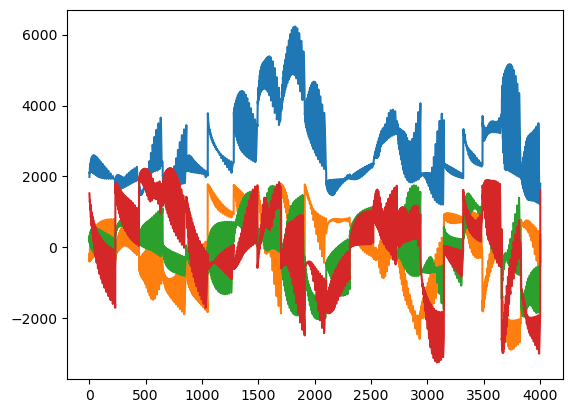

In [191]:
# from scipy.sparse import csc_matrix
# from scipy.sparse.linalg import lsqr
#plot the computed groundstate
plt.plot(lam[::4])
plt.plot(lam[1::4])
plt.plot(lam[2::4])
plt.plot(lam[3::4])
print(np.max(lam),np.linalg.norm(lam))
plt.show()

In [193]:
#heretim
#DONE: wrap from here to V_out
#TODO: wrap all this in a routine
#DONE: make it as fast as possible (first)
x,Lp,ome = map_real_lam_to_vertices(lam,V,T,printing=True,use_return_Lp=True)#,**kwargs)

Progress: |██████████████████████████████████████████████████| 100.0% Complete
Performing linear algebra solve...
linear solve complete!
the number of iterations used for linear algebra solve: istop=1
returning Lp,ome: Lp.shape=(16008, 16008), ome.shape=(16008,)
np.min(L)=-0.726143,np.max(L)=3.630589
np.min(ome)=-689032.182758,np.max(ome)=455408.937968


In [194]:
om=x.copy()
#center result
om = om.reshape((nV,4))
om = om - np.broadcast_to(np.mean(om,axis=0), shape=(nV,4), subok=False)
#normalize output mesh
nrm = np.sum(om*om,axis=0)
# nrm=sum(ome.*ome,1);
ome_out=om/np.sqrt(np.max(nrm))
# ome_out=om#/np.sqrt(np.max(nrm))
# ome=ome/sqrt(max(nrm));
V_out = ome_out[:,1:]
scalar_out = ome_out[:,0]
# V=ome(2:end,:);
print(f"\nQ: is the smallest value in the first index?\m")
print(f"*** Norm: {list(nrm)} ***")
# np.min(scalar_out),np.max(scalar_out)
assert vert.shape==V_out.shape
assert not np.isnan(V_out).any()
# np.max(np.abs(V_out)),np.mean(np.abs(V_out))
V_out.dtype,V_out.shape


Q: is the smallest value in the first index?\m
*** Norm: [3.270712513861542e-19, 1.511278674331134e+17, 1.0615128924997118e+17, 1.4068305079154493e+17] ***


(dtype('float64'), (4002, 3))

In [195]:
#normalize output mesh
nrm = np.sum(ome_out*ome_out,axis=0)
# # nrm=sum(ome.*ome,1);
# ome_out=om/np.sqrt(np.max(nrm))
# # ome_out=om#/np.sqrt(np.max(nrm))
# # ome=ome/sqrt(max(nrm));
# V_out = ome_out[:,1:]
# scalar_out = ome_out[:,0]
# # V=ome(2:end,:);
print(f"\nQ: is the smallest value in the first index?\m")
print(f"*** Norm: {list(nrm)} ***")
# V_out = om[:,1:]
# scalar_out = om[:,0]
# np.min(scalar_out),np.max(scalar_out)
# np.max(np.abs(V_out)),np.mean(np.abs(V_out))


Q: is the smallest value in the first index?\m
*** Norm: [2.164202121960796e-36, 0.9999999999999979, 0.7023938804466475, 0.9308875535731954] ***


In [196]:
#visualize the output mesh
# initialize mesh colored by rho
mesh_out = trimesh.Trimesh(vertices=V_out,faces=tria,
                       face_colors=colors,
                       face_attributes={'rho':rho})
mesh_out.vertices-=mesh_out.center_mass
#normalize output mesh
# mesh_out.vertices/=np.sign(mesh_out.volume)*np.abs(mesh_out.volume)**0.33
mesh_out.vertices*=np.sign(mesh_out.volume) #account for double cover edge case from quaternionic representation
mesh_out.vertices/=np.abs(mesh_out.bounding_sphere.volume)**0.33
nrm = np.sum(mesh_out.vertices*mesh_out.vertices,axis=0)

# mesh_out.vertices/=np.abs(mesh_out.bounding_sphere.volume)**0.33

# #(unecessary?) repair mesh
# trimesh.repair.fix_inversion(mesh_out)
# trimesh.repair.fix_normals(mesh_out)
# trimesh.repair.fix_winding(mesh_out)

#print mesh bluf
print(f"{mesh_out.is_watertight=}")
print(f"{mesh_out.volume=}")
print(f"{(mesh_out.volume/mesh_out.bounding_sphere.volume)=} (volume relative to smallest bounding sphere)")
print(f"{mesh_out.center_mass=}")
print(f"rms norm of mesh vertices: {list(np.sqrt(nrm))} pixels")
print(f"{mesh_out.is_watertight=} (is the current mesh watertight?)")
print(f"{mesh_out.euler_number=} (what's the euler number for the mesh?)")
print(f"volume relative to smallest bounding sphere: {(mesh_out.volume/mesh_out.bounding_sphere.volume)=}")
beep(3)
mesh_out.show()

mesh_out.is_watertight=True
mesh_out.volume=0.4466583909100834
(mesh_out.volume/mesh_out.bounding_sphere.volume)=0.48422211679606275 (volume relative to smallest bounding sphere)
mesh_out.center_mass=array([ 1.74770155e-17, -2.07134999e-17, -1.55351249e-17])
rms norm of mesh vertices: [18.878772804461775, 16.31057427032728, 14.763202656767488] pixels
mesh_out.is_watertight=True (is the current mesh watertight?)
mesh_out.euler_number=2 (what's the euler number for the mesh?)
volume relative to smallest bounding sphere: (mesh_out.volume/mesh_out.bounding_sphere.volume)=0.48422211679606275


In [197]:
volume_initial = mesh.volume#=4.182994798204928
volume_final = mesh_out.volume#=4.182994798204928
print(f"{volume_initial=:.4f} voxels, {volume_final=:.4f} voxels")
print(f"{mesh.bounding_sphere.volume=:.4f} voxels, {mesh_out.bounding_sphere.volume=:.4f} voxels")
print(f"{volume_initial/mesh.bounding_sphere.volume=:.4f} voxels, {volume_final/mesh_out.bounding_sphere.volume=:.4f} voxels")
#compute the percent change in relative volume
relative_volume_initial = volume_initial/mesh.bounding_sphere.volume
change_in_relative_volume = volume_final/mesh_out.bounding_sphere.volume - volume_initial/mesh.bounding_sphere.volume
relative_change_in_relative_volume = change_in_relative_volume / relative_volume_initial
print(f"percent change in relative volume: {relative_change_in_relative_volume:.4%}")

volume_initial=4.1830 voxels, volume_final=0.4467 voxels
mesh.bounding_sphere.volume=4.1888 voxels, mesh_out.bounding_sphere.volume=0.9224 voxels
volume_initial/mesh.bounding_sphere.volume=0.9986 voxels, volume_final/mesh_out.bounding_sphere.volume=0.4842 voxels
percent change in relative volume: -51.5105%


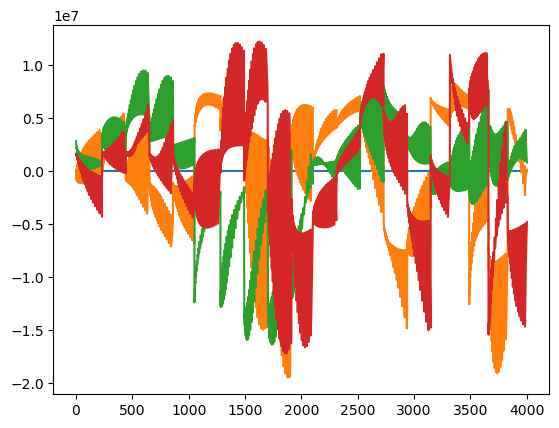

In [198]:
#plot the computed groundstate
# plt.plot(x[::4])
# plt.plot(x[1::4])
# plt.plot(x[2::4])
# plt.plot(x[3::4])
# plt.show()
#plot the computed vertex representation of the transformation
plt.plot(om[:,0])
plt.plot(om[:,1])
plt.plot(om[:,2])
plt.plot(om[:,3])
plt.show()

# scratchwerk

## scratchwerk

In [ ]:
# #>10 minute run time...
# Linv = np.linalg.pinv(L)
#DONE: try the pseudo inverse L instead

In [ ]:
#test the inverted matrix has only valid entries
assert not np.isnan(Linv).any()
assert not np.isinf(Linv).any()

In [ ]:
#run time >10 minutes
# # print(np.around((Linv[-9:,-9:]),3))
# # print(np.around((Linv[:9,:9]),1))
# U, S, V = np.linalg.svd(L, full_matrices=False)
# U.shape, S.shape, V.shape 

In [ ]:
# vmax=0.01
# vmax=0.001
vmax=0.0001
figsize=(4,4)
# figsize=(7,7)
fig,ax=plt.subplots(figsize=(7,7))
ax.imshow(Lp,
    cmap='bwr',
# #     norm=None,
# #     aspect=None,
# #     interpolation=None,
# #     alpha=None,
    vmin=-vmax,
    vmax=vmax)
# format_plot
# format_plot(ax=ax,xlabel=r'n (1/cm$^2$)',ylabel=r'w (Hz/cm$^2$)',fontsize=fontsize)#,use_loglog=True)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(top=True, right=True,direction='in',which='both')
plt.tight_layout()
plt.show()

In [ ]:
print(np.min(L),np.max(L))
print(np.min(Linv),np.max(Linv))
# -0.7261430355213236 3.630588505800929
# -42089716143649.945 0.0

# from here in python:
# print(np.min(L),np.max(L))
# -0.7261430355213236 3.630588505800929
#from matlab:
# min(L): -7.261430e-01, max(L): 3.630589e+00

In [ ]:
#DONE: visualize the pointcloud of ome_raw@Linv
#DONE: visualize the pointcloud of Linv@ome_raw
#NOTE: none of them look right

In [ ]:
# # #test the inverse matrix works with right multiplication
# roo = np.abs( (L@Linv) - np.eye(L.shape[0]))
# print(roo[:3,:3])
# np.min(roo),np.max(roo) #1?? sig figs of agreement (17% error)
# # # [[0.00097656 0.         0.        ]
# # #  [0.         0.0078125  0.        ]
# # #  [0.         0.         0.0078125 ]]
# # # (0.0, 0.171875)
# # [[0.00585938 0.         0.        ]
# #  [0.         0.046875   0.        ]
# #  [0.         0.         0.046875  ]]

In [ ]:
# # #test the inverse matrix works with right multiplication
# roo = np.abs( (Linv@L) - np.eye(L.shape[0]))
# print(roo[:3,:3])
# np.min(roo),np.max(roo) #14?? sig figs of agreement (17% error)
# # # [[0.01855469 0.         0.        ]
# # #  [0.         0.08984375 0.        ]
# # #  [0.         0.         0.08984375]]
# # # (0.0, 0.2578125)
# # [[0.02148438 0.         0.        ]
# #  [0.         0.1015625  0.        ]
# #  [0.         0.         0.1015625 ]]

In [ ]:
#OBSERVATION: precomputing Linv doesn't work perfectly
#~1 minute run time and off by ~ 6 %...
# L@Linv
#~1 minute run time and off by ~ 10 %...
# Linv@L

In [ ]:
# #ROOT CAUSE DETECTED? constant shift from 1 indexing...
# #SOLVED
# # - in matlab the first element is 1,2,3
# # - in python the first element is 0,-1,-2,
# # (...)>> try shifting ome_raw before reshaping it
# # ome_raw==ome_raw.T
# np.mean(ome_raw.reshape((nV,4)),axis=0)
# #Q: which axis has the smallest mean value? shift so that goes to 0 some way or another.

In [ ]:
# #DONE: checked swap isn't incorrect...
# k1=0;k2=1;k3=2
# print(f"{k1=}, {k2=}, {k3=}")
# k3=k1; k1=k2; k2=k3; #% swap
# print(f"{k1=}, {k2=}, {k3=}")


In [ ]:
#DONE: check that I'm not using x/L (pointwise division) anywhere...

In [ ]:
# np.min(ome),np.max(ome),np.mean(ome),np.var(ome)

In [ ]:
# # Potential ROOT CAUSE: 
# # Q: Am I casting from quaternion to cartesian incorrectly?
# #NOTE: om is in the basis of 1ijk
# #NOTE: ome is in the basis of 1ijk
# #NOTE: L is in the basis of quaternions
# # om = om.reshape((nV,4))
# ome_l.shape,ome_r.shape,Linv.shape,L.shape,om.shape

# #maxabs percent difference of 42% between left and right division suggests which one i use really matters...
# #maxabs percent difference of 13% between left and right division suggests which one i use really matters...
# np.max(np.abs(ome_r-ome_l))/np.max(np.abs(ome_r))

In [ ]:
#>10 minutes of run time
# # divisor=np.roll(Linv,(12,12))
# divisor=np.roll(L,(12,12))
# om = np.linalg.lstsq(divisor.T, ome.T)[0].T
# om.shape

In [ ]:
#center result
ome = ome_raw.reshape((nV,4))
# ome = ome_raw.T.reshape((nV,4)) #<<<same thing
# Q: which one of ^these is correct?
# ome = ome_raw.reshape((4,nV))
ome = ome - np.broadcast_to(np.mean(ome,axis=0), shape=(nV,4), subok=False)
# ome.reshape((4,nV))
# ome=reshape(ome,[4 nV]);
# ome=ome-repmat(mean(ome,2),[1 nV]);
ome = ome.flatten()
# ome=reshape(ome,[4*nV 1]);
# om = ome@Linv
om = Linv@ome
# om = Linv.T@ome
print(om.shape)
# np.divide?
om1=om.copy()

In [ ]:
#compute the vector `x` that approximately solves the equation
# ``a @ x = b``.

#this will take 17-22 minutes to rerun...
# om = Linv@ome #the incumbant
om2 = np.linalg.lstsq(Lp, ome)[0]    # not under-determined

In [ ]:
#plot the computed groundstate
plt.plot(om2[::4])
plt.plot(om2[1::4])
plt.plot(om2[2::4])
plt.plot(om2[3::4])

In [ ]:
# cp.sparse.cupyx.optimizing.optimize?
# cholesky decomposition doesn't explicitely solve least-squares. 
# cp.sparse.cupyx.linalg.sparse.lschol(A,b)
# cp.sparse.cupyx.linalg.invh?
# cp.sparse.cupyx.linalg.sparse.lschol?

In [ ]:
# a=Lp.copy()
# b=ome.copy()
# x0=Linv@b

In [ ]:

#DONE: try scipy.sparse or something lstsq in scipy
#DONT: block-solve upper-triangular / lu decomposition or something to make it go faster

In [ ]:
#GOAL: dev map Linv,ome,Lp to ome_refined=x
# <--->  x minimizes the Euclidean 2-norm `|| b - a x ||^2`
# def lsq_solve_pytorch(a,x0,b):
#     pass
# <--->  x minimizes the Euclidean 2-norm `|| b - a x ||^2`
# def lsq_solve_scipy(a,x0,b):
#     pass
#TODO: implement gradient-descent approach to map Linv,ome,Lp to Linv_refined in numpy/cupy?
#TODO: implement gradient-descent approach to map Linv,ome,Lp to Linv_refined in pytorch
#TODO: try using the iterative method from before to find the groundstate eigensolution lam, to E*lam = res*lam

In [ ]:
# np.linalg.norm(x)

In [ ]:
print(f"Root-Mean-Square-Error between numpy and scipy least-square solutions: {rmse=:.4f}")
rmse = np.sqrt(np.linalg.norm(x-om2))
print(f"Solution Norms: (scipy soln, numpy soln)")
print(f"- {np.linalg.norm(x)=:.6f}, {np.linalg.norm(om2)=:.6f}")
print(f"- {np.linalg.norm(x**2)=:.10f}, {np.linalg.norm(om2**2)=:.10f}")
# mpe=np.mean(np.abs(x-om2)/x)
# print(f"{mpe=:}")

In [ ]:

# cp.sparse.cupyx.lapack.gesv?

In [ ]:
# Lpc=cp.array(Lp)
# Lpc.shape

In [ ]:
# omec=cp.array(ome)

In [ ]:
# #speed-up this step in cp
# retval_c = cp.linalg.lstsq(Lpc, omec)    # not under-determined
# (om2c, residuals, rank, s) = retval_c
# #  OutOfMemoryError: Out of memory allocating 2,067,344,896 bytes (allocated so far: 6,150,403,072 bytes). 

In [ ]:
# om2=om2c.get()

In [ ]:

# # om2,residuals2,rank2,singular_value_array2=retval_
# # om2,residuals2,rank2=retval_
# # om2,residuals2=retval_
# om2=retval_
# om2.shape

In [ ]:
# beep(7)

In [ ]:
# # om = ome@Linv #the transpose. not the same as solving ``a @ x = b``.
# om3,residuals3,rank3,singular_value_array3 = np.linalg.lstsq(Lp.T, ome)[0]    # not under-determined
# om3.shape

## DONE: Plot V_out / more scratchwerk

In [96]:
V_out.dtype

dtype('float64')

In [99]:
#visualize the output mesh
# initialize mesh colored by rho
mesh_out = trimesh.Trimesh(vertices=V_out,faces=tria,
                       face_colors=colors,
                       face_attributes={'rho':rho})

print(f"{mesh_out.is_watertight=}")
mesh_out.show()
# ****
#print mesh bluf
print(f"{mesh_out.volume=}")
print(f"{mesh_out.center_mass=}")
print(f"{mesh_out.is_watertight=} (is the current mesh watertight?)")
print(f"{mesh_out.euler_number=} (what's the euler number for the mesh?)")

In [102]:
beep(3)
#Q: does adding/subtracting 1 from every vertex index in tria help?
# A: no.
# HINT: 
# tria_=tria-1
# tria_=tria+1




0

In [ ]:
# #caution really slow...
# #Q: does slerp use something like exponential interpolation?
# dt=1e-2
# dlp=scipy.linalg.logm(Lp)
# Lp_next = scipy.linalg.expm(dt*dlp)
# rmsd = np.sqrt(((Lp_next-Lp)[:,0]**2).mean())
# print(f"exponentially rotating the deformation matrix by {dt=}: {rmsd=}")

In [ ]:
# # Q: can I get a given state of eigenspectrum this way?
# #get the first two eigenvectors
# Ab = decomp_banded_matrix(A=E)
# w, v = scipy.linalg.eig_banded(Ab, lower=True, select='v', select_range=[0,1])

# #>3 minute runtime...
# #get all eigenvectors
# # w, v = eig_banded(E, lower=True)

In [ ]:
# import numpy as np
# from scipy.linalg import eig_banded
# A = np.array([[1, 5, 2, 0], [5, 2, 5, 2], [2, 5, 3, 5], [0, 2, 5, 4]])
# Ab = np.array([[1, 2, 3, 4], [5, 5, 5, 0], [2, 2, 0, 0]])
# w, v = eig_banded(Ab, lower=True)
# np.allclose(A @ v - v @ np.diag(w), np.zeros((4, 4)))
# True
# w = eig_banded(Ab, lower=True, eigvals_only=True)
# w

# w, v = eig_banded(Ab, lower=True, select='v', select_range=[-3, 4])
# w.shape,v.shape,Ab.shape



In [ ]:
# import numpy as np
# from scipy.linalg import cholesky_banded, cho_solve_banded
# Ab = np.array([[0, 0, 1j, 2, 3j], [0, -1, -2, 3, 4], [9, 8, 7, 6, 9]])
# A = np.diag(Ab[0,2:], k=2) + np.diag(Ab[1,1:], k=1)
# A = A + A.conj().T + np.diag(Ab[2, :])
# c = cholesky_banded(Ab)
# x = cho_solve_banded((c, False), np.ones(5))

In [ ]:
#Eco_ = cho_solve_banded((cholesky_banded(E), False), lower=True)

In [ ]:
#Eco_.shape

In [ ]:
#Eco___

In [ ]:
# # i=0
# i=-1
# # ome = vh[int(i)].reshape((nV,4))
# # ome = vh[int(i)].reshape((nV,4))
# ome = ome_raw.reshape((nV,4))

# #center result
# ome = ome - np.broadcast_to(np.mean(ome,axis=0), shape=(nV,4), subok=False)
# ome = ome.flatten()
# #map result
# # om = ome.copy()
# # om = ome@Linv
# om = Linv@ome#@Linv
# # om = Linv@ome
# # om = Linv.T@ome
# #center result
# om = om.reshape((nV,4))
# om = om - np.broadcast_to(np.mean(om,axis=0), shape=(nV,4), subok=False)
# #normalize output mesh
# nrm = np.sum(om*om,axis=0)
# ome_out=om/np.sqrt(np.max(nrm))
# # ome_out=om
# V_out = ome_out[:,1:]
# scalar_out = ome_out[:,0]
# # V_out=ome(2:end,:);
# print(f"\nQ: is the smallest value in the first index?\m")
# print(f"*** Norm: {list(nrm)} ***")
# print(np.min(scalar_out),np.max(scalar_out))
# assert vert.shape==V_out.shape
# assert not np.isnan(V_out).any()
# print(np.max(np.abs(V_out)),np.mean(np.abs(V_out)))
# print(f"{V_out.dtype=}")

# #Q: does permuting triangles by +/- 1-3 fix make it smooth?
# #A: no. however, it does shift the colors while not affecting the geometry...

#shift the colors
# tria_=tria.copy()
# # tria_=tria.copy()
# tria_=np.roll(tria,-1,axis=1)  
 

# # tria_=np.roll(tria,1,axis=0)  #<< makes funny color streaks
# # tria_=np.roll(tria,100,axis=0) #<< roughly shuffled colors
# # V_out = V_out[:,(0,1,2)].copy() #
# #  V_out = V_out[:,(0,2,1)].copy() #*
# # V_out = V_out[:,(1,0,2)].copy() #*
# # V_out = V_out[:,(1,2,0)].copy() #*
# # V_out = V_out[:,(2,1,0)].copy()
# # V_out = V_out[:,(2,0,1)].copy()
# #visualize the output mesh
# # initialize mesh colored by rho
# # mesh_out = trimesh.Trimesh(vertices=V_out,faces=tria,
# mesh_out = trimesh.Trimesh(vertices=V_out,faces=tria_,
#                        face_colors=colors,
#                        face_attributes={'rho':rho},alpha=0.5)

# print(f"{mesh_out.is_watertight=}")
# mesh_out.show()
# # ****
# # is the current mesh watertight?

In [ ]:
#<12 minute runtime
wh, vh = np.linalg.eigh(Lp)
wh.shape,vh.shape

In [ ]:
# print(np.isclose(wh,1,atol=5e-3).sum(),wh.shape[0])
print(f'{np.isclose(wh,1,atol=5e-3).sum():d} out of {wh.shape[0]:d} linearly independent dimensions has an eigenvalue very close to unity...')

In [ ]:
# lamh = vh[np.argmin(wh)]
lamh = vh[wh==1]
lamh.shape

In [ ]:
for i in np.argwhere(np.isclose(wh,1,atol=5e-3)):
    print(f"{i=}")

In [ ]:
# # i=0
# i=-1
# # ome = vh[int(i)].reshape((nV,4))
# ome = vh[int(i)].reshape((nV,4))
# ome = ome_raw.reshape((nV,4))

# #center result
# ome = ome - np.broadcast_to(np.mean(ome,axis=0), shape=(nV,4), subok=False)
# ome = ome.flatten()
# #map result
# # om = ome.copy()
# # om = ome@Linv
# om = Linv@ome#@Linv
# # om = Linv@ome
# # om = Linv.T@ome
# #center result
# om = om.reshape((nV,4))
# om = om - np.broadcast_to(np.mean(om,axis=0), shape=(nV,4), subok=False)
# #normalize output mesh
# nrm = np.sum(om*om,axis=0)
# ome_out=om/np.sqrt(np.max(nrm))
# # ome_out=om
# V_out = ome_out[:,1:]
# scalar_out = ome_out[:,0]
# # V_out=ome(2:end,:);
# print(f"\nQ: is the smallest value in the first index?\m")
# print(f"*** Norm: {list(nrm)} ***")
# print(np.min(scalar_out),np.max(scalar_out))
# assert vert.shape==V_out.shape
# assert not np.isnan(V_out).any()
# print(np.max(np.abs(V_out)),np.mean(np.abs(V_out)))
# print(f"{V_out.dtype=}")

# #Q: does permuting triangles by +/- 1-3 fix make it smooth?
# #A: no. however, it does shift the colors while not affecting the geometry...
# tria_=tria.copy()
# # tria_=np.roll(tria,1,axis=0)  #<< makes funny color streaks
# # tria_=np.roll(tria,100,axis=0) #<< roughly shuffled colors
# # V_out = V_out[:,(0,1,2)].copy() #
# #  V_out = V_out[:,(0,2,1)].copy() #*
# # V_out = V_out[:,(1,0,2)].copy() #*
# # V_out = V_out[:,(1,2,0)].copy() #*
# # V_out = V_out[:,(2,1,0)].copy()
# # V_out = V_out[:,(2,0,1)].copy()
# #visualize the output mesh
# # initialize mesh colored by rho
# # mesh_out = trimesh.Trimesh(vertices=V_out,faces=tria,
# mesh_out = trimesh.Trimesh(vertices=V_out,faces=tria_,
#                        face_colors=colors,
#                        face_attributes={'rho':rho},alpha=0.5)

# print(f"{mesh_out.is_watertight=}")
# mesh_out.show()
# # ****
# # is the current mesh watertight?

In [ ]:
# np.outer(Lp@vh[i],vh[i])#.shape,(Lp@vh[i]).shape

In [ ]:
# np.dot(Lp,vh[i]).sum(),wh[i],np.linalg.norm(vh[i])

In [ ]:
# wh[i]

In [ ]:
# #plot the computed groundstate
# plt.plot(lam[::4])
# plt.plot(lam[1::4])
# plt.plot(lam[2::4])
# plt.plot(lam[3::4])

#plot the eigensolution for the groundstate
plt.plot(lamh[::4])
plt.plot(lamh[1::4])
plt.plot(lamh[2::4])
plt.plot(lamh[3::4])

In [ ]:
plt.plot(wh)

In [ ]:
#intentionally cause an error to avoice noming gpu memory
Lpcinv

In [ ]:
#visualize ^this eigensolution using trimesh, as before
#TODO: wrap this to foo

In [ ]:
Lpc=cp.array(Lp)
Lpc.shape

In [ ]:
#TODO: compute w,v using cupy
wg,vg = cp.linalg.eigvalsh(Lpc)
wg.shape

In [ ]:
# Lpcinv = cupyx.linalg.invh(Lpc)

In [ ]:
# import cupy
mempool = cupy.get_default_memory_pool()
pinned_mempool = cupy.get_default_pinned_memory_pool()

In [ ]:
print(mempool.used_bytes())              
print(mempool.total_bytes())             
print(pinned_mempool.n_free_blocks())

In [ ]:
#run gpu cleanup
# del Lpc,wg,vg#Lpcinv
mempool.free_all_blocks()

print(mempool.used_bytes())              
print(mempool.total_bytes())             
print(pinned_mempool.n_free_blocks())

In [ ]:
#TODO: compute w,v using cupy
# HINT: use solve
#solve ax=b
# cupy.linalg.solve?
#note: this took <11 seconds to run
x_soln = cp.linalg.solve(a=Lpc, b=cp.zeros(Lp.shape[0]))
x_soln.shape

In [ ]:
# lamg = x_soln.get()
# type(lamg)
# # #plot the computed groundstate
# # plt.plot(lam[::4])
# # plt.plot(lam[1::4])
# # plt.plot(lam[2::4])
# # plt.plot(lam[3::4])

# # #plot the eigensolution for the groundstate
# # plt.plot(lamh[::4])
# # plt.plot(lamh[1::4])
# # plt.plot(lamh[2::4])
# # plt.plot(lamh[3::4])

# #plot the eigensolution for the groundstate
# plt.plot(lamg[::4])
# plt.plot(lamg[1::4])
# plt.plot(lamg[2::4])
# plt.plot(lamg[3::4])

In [ ]:
lamg

In [ ]:
# import cupyx

In [ ]:
# cupyx.scipy.sparse.linalg.lsqr

In [ ]:
# cupyx.scipy.sparse.csr_matrix
# cupyx

In [ ]:
# Q: why is my mesh so noisier than the demo solution from matlab?

In [ ]:
# #warning: #>16 minutes run time
# #53-37 = >16 
# w, v = np.linalg.eig(E)
# w.shape,v.shape,np.min(w),np.max(w) 
# #for simplest unit sphere example:
# # ((264,),
# #  (264, 264),
# #  (-6.216318184123621-3.508736056987371j),
# #  (10.372886477259154+0j))

# #warning >7 minutes run time
# wh, vh = np.linalg.eigh(E)
# wh.shape,vh.shape,np.min(wh),np.max(wh)

In [ ]:
#TODO: test that changing E's dtype to float 64 doesn't make everything immediately better
#TODO: improve this method
#Option 1: keep looking for mistakes somewhere...
#Option 2: improve estimation of lam. get a better solution bc >10% error in ground state eigenvector would explain the numerical noise...
#   - 2.A: try canned response from cupy.linalg
#   - 2.A: try simplest possible pytorch routine
#   - 2.C: try pycuda


In [ ]:
# import cupy as cp

In [ ]:
# E.dtype

In [ ]:
#TODO: get the demo working to machine precision
#HINT: check the matlab code to see if i'm missing any [plc] reindexing...
#TODO: attempt to solve the linear system of equations more explicitely       
#HINT: try adding res to rho
#TODO: set rho to a constant value everywhere and see if i get a sphere coming out
#TODO: can i get dirac spheres at the harmonics (n>1)

In [ ]:
#Q: did shifting the other direction help?
#A: no.

# #Q: does settingrho=0 return the identity morphism?
# #A: no.
# #TODO: figure out why I'm not able to get the identity morphism

# # Q: does permuting tria help?
#A: unlikely to be watertight...

In [ ]:
# plt.plot(lam) #<<< lam appears to agree with matlab

In [ ]:
# #heretim
# #TODO: visualize the pointcloud of ome_raw
# x_values = ome_raw[1::4]
# y_values = ome_raw[2::4]
# z_values = ome_raw[3::4]
# c_values = ome_raw[0::4]


# x_values = (Linv@ome_raw)[1::4]
# y_values = (Linv@ome_raw)[2::4]
# z_values = (Linv@ome_raw)[3::4]
# c_values = (Linv@ome_raw)[0::4]

# x_values = (ome_raw@Linv)[1::4]
# y_values = (ome_raw@Linv)[2::4]
# z_values = (ome_raw@Linv)[3::4]
# c_values = (ome_raw@Linv)[0::4]

# x_values = V[:,0]
# y_values = V[:,1]
# z_values = V[:,2]
# c_values = 0.*x_values

# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# ax.scatter(xs=x_values,ys=y_values,zs=z_values,c=c_values,alpha=0.7,s=10)
# plt.show()

In [ ]:
V_out = ome_out[:,1:]
# V_out = ome_out[:,:3]
# V_out = ome_out[:,:3]

#TODO: plot the resultant point cloud
# x_values = V[:,0]
# y_values = V[:,1]
# z_values = V[:,2]
x_values = V_out[:,0]
y_values = V_out[:,1]
z_values = V_out[:,2]

c_values = 0.*x_values
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(xs=x_values,ys=y_values,zs=z_values,c=c_values,alpha=0.3,s=10)
plt.show()
V_out.shape

In [ ]:
# is the current mesh watertight?
print(f"{mesh_out.is_watertight=}")
# what's the euler number for the mesh?
print(f"{mesh_out.euler_number=}")
# the convex hull is another Trimesh object that is available as a property
# lets compare the volume of our mesh with the volume of its convex hull
print(f"{mesh_out.volume / mesh_out.convex_hull.volume=:.7f}")
# # since the mesh is watertight, it means there is a
# # volumetric center of mass which we can set as the origin for our mesh
print(f"{mesh_out.center_mass=}")
# mesh.vertices -= mesh.center_mass
# print(f"{mesh.center_mass=}")
# what's the moment of inertia for the mesh?
print(f"{mesh_out.moment_inertia=}")

# axis aligned bounding box is available
print(f"{mesh_out.bounding_box.extents=}")

In [ ]:
########################################
# Option #1: do what WJ asked me to do
########################################
# - update uncertainties for simulated annealing fits using 10X epochs instead of 10X more epochs
# - add bigger domain sizes to Figure S3 for the FK model
# - add dotted exponential fit to fig. S2C-D showing tau(N0) scales exponentially with A for N0=2,2s0.


In [ ]:
# # Option #2: aimlessly look for a bug between *** and **** on ub using cupy to do np.linalg.inv
# # TODO: debug mesh_out showing wrong
# # HINT: add more print statements to spin.m and look for the values that do not agree
# # TODO(later): use cupy.linalg.inv
# # - link to doc on ibid: https://docs.cupy.dev/en/stable/reference/generated/cupy.linalg.inv.html
# # HINT: before debugging aimlessly between *** and ****, try np.dot everywhere
# # hint(ub): if doing Option #2, then gpu accelrerate any matrix inversions (only) 
# #TODO(later?): compute matrix a_inv from n-dimensional regular matrix a such that dot(a, a_inv) == eye(n).
# a = cp.array(E)
# a = cp.array(L)
# a_inv = cp.linalg.inv (a)
# n=a_inv.shape[0]
# assert n==a.shape[0]
# assert n==a.shape[1]
# assert (cp.dot(a, a_inv) == eye(n)).get().all()
# Einv = a_inv.get()
# Linv = L_inv.get()

In [ ]:
# invh_banded
A=E
N = np.shape(A)[0]
# D = np.count_nonzero(A[0,:])
D=np.max(np.count_nonzero(A,axis=1))
ab = np.zeros((D,A.shape[0]))
for i in np.arange(1,D):
    ab[i,:] = np.concatenate((np.diag(A,k=i),np.zeros(i,)),axis=None)
ab[0,:] = np.diag(A,k=0)
ab.shape,ab.dtype

# plt.plot(np.count_nonzero(A,axis=1))
for i in np.arange(1,D):
    plt.plot(ab[i],lw=0.5,alpha=0.4,label=f'band #{i}')
# AddLegend()
format_plot(xlabel='Vertex Coordinate',ylabel='Matrix Element')
ax.tick_params(top=True, right=True,direction='in',which='both')
plt.tight_layout()
plt.show()

# plt.plot(np.count_nonzero(A,axis=1))
for i in np.arange(1,D):
    plt.plot(ab[i]**2,lw=0.5,alpha=0.4,label=f'band #{i}')
format_plot(xlabel='Vertex Coordinate',ylabel='Matrix Element Squared')
ax.tick_params(top=True, right=True,direction='in',which='both')
plt.tight_layout()
plt.show()

plt.plot(np.sqrt(np.sum(ab**2,axis=0)), c='k',alpha=0.7,label="(Band-Avg.)")
format_plot(xlabel='Vertex Coordinate',ylabel='RMS Matrix Element')
ax.tick_params(top=True, right=True,direction='in',which='both')
plt.tight_layout()
plt.show()

rmsme = np.sqrt(np.sum(ab**2,axis=0))

# rmsme.shape

alpha=0.5
fontsize=16
fig,ax=plt.subplots(figsize=(9,4))
ax.plot(rmsme[::4], alpha=alpha)#c='k',alpha=0.7)
ax.plot(rmsme[1::4], alpha=alpha)#
ax.plot(rmsme[2::4], alpha=alpha)#
ax.plot(rmsme[3::4], alpha=alpha)#
format_plot(ax=ax,xlabel='Vertex Index',ylabel=r'Band Avg.',fontsize=fontsize)
# ax.set_title("Equal Band Averages in Each Dimension\n"+'\n',fontsize=16)
ax.tick_params(top=True, right=True,direction='in',which='both')
plt.tight_layout()
plt.show()

alpha=0.8
fontsize=16
fig,ax=plt.subplots(figsize=(4,4))
ax.plot(rmsme[::4], alpha=alpha)#c='k',alpha=0.7)
ax.plot(rmsme[1::4]+1, alpha=alpha)#
ax.plot(rmsme[2::4]+2, alpha=alpha)#
ax.plot(rmsme[3::4]+3, alpha=alpha)#
format_plot(ax=ax,xlabel='Vertex Index',ylabel=r'Band Avg. $+ d$',fontsize=fontsize)
ax.set_title("Equal Band Averages in Each Dimension\n"+r"( for $d=0,1,2,3$;  $1:x,2:y,3:z$ )"+'\n',fontsize=16)
ax.tick_params(top=True, right=True,direction='in',which='both')
plt.tight_layout()
plt.show()

In [ ]:
#DONE(failing ^this): try computing L 
#   with right multiplying to get lam
# Q: did ^that work?
# A: not immediately...

In [ ]:
#TODO(failing ^this): make sure E is being constructed correctly?
# Q: are the data points being caste like how L is constructed?
#TODO(am I indexing everyting consistently?)

In [ ]:
#TODO(if ^this works): speed up matrix inversion with scipy.sparse.linalg
#

In [ ]:
#TODO(failing ^this): consider reimplementing using another method
# numpy-quaternion lacks linear algebra solving
# quaternionic may lack linear algebra solving
# complex matrix representation is straightforward and probably faster than the real representation
#note: it's hard to implement quaternions in low-level cuda... but not complex matrix linear algebra...

In [ ]:
#TODO(later): take eigenvalue decomposition of a working example
#TODO: plot the ground state
#TODO: plot the excited states
# boo_real = np.around(np.imag(vals),7)==0
# lam_grnd = np.real(np.min(vals[boo_real]))
# vec_grnd = vecs[:,lam_grnd==vals]
# print(f"{lam_grnd=}")
# # vec_grnd = vecs[:,2]
# assert (np.imag(vec_grnd)==0).all()
# vec_grnd = np.real(vec_grnd)
# plt.plot(vec_grnd)



# scipy.linalg.eig?
# scipy.linalg.eigh?
# scipy.linalg.schur

# # scipy.sparse.linalg.eigs?
# # maxiter =    Maximum number of Arnoldi update iterations allowed
# Notes
# -----
# This function is a wrapper to the ARPACK [1]_ SNEUPD, DNEUPD, CNEUPD,
# ZNEUPD, functions which use the Implicitly Restarted Arnoldi Method to
# find the eigenvalues and eigenvectors [2]_.

# References
# ----------
# .. [1] ARPACK Software, http://www.caam.rice.edu/software/ARPACK/
# .. [2] R. B. Lehoucq, D. C. Sorensen, and C. Yang,  ARPACK USERS GUIDE:
#    Solution of Large Scale Eigenvalue Problems by Implicitly Restarted
#    Arnoldi Methods. SIAM, Philadelphia, PA, 1998.

# # scipy.sparse.linalg.svds
# # scipy.sparse.linalg.eigsh
# vals, vecs = scipy.sparse.linalg.eigs(np.eye(13), k=6)
# print(*vals)
# vals.shape, vecs.shape

# eigvals : eigenvalues of a non-symmetric array.
#^that's not what I want
# eigh : eigenvalues and eigenvectors of a real symmetric or complex
#        Hermitian (conjugate symmetric) array.
#^that's what I want
#eigvalsh : eigenvalues of a real symmetric or complex Hermitian
#            (conjugate symmetric) array.
#^that's not what I want
# scipy.linalg.eig : Similar function in SciPy that also solves the
#                    generalized eigenvalue problem.
#^that's probably slow
# scipy.linalg.schur : Best choice for unitary and other non-Hermitian
#                      normal matrices.
#^that's probably slow

#TODO: find the ground state
# lam_grnd



# TODO(later): determine fastest way to invert a 10000x10000 matrix of quaternions on 1 cpu
- better, TODO: speed up by using complex quaternion representation.

In [ ]:
import quaternion

In [ ]:
# import quaternionic

In [ ]:
# a.shape

# a = np.random.rand(10000, 10000,4)
# qs = np.quaternion(a)
# qs

# qs = a.astype(dtype=np.quaternion)



# a = np.random.rand(10000, 10000*4)
# # a
# # array([[ 0.93138726,  0.46972279,  0.18706385,  0.86605021],
# #        [ 0.70633523,  0.69982741,  0.93303559,  0.61440879],
# #        [ 0.79334456,  0.65912598,  0.0711557 ,  0.46622885],
# #        [ 0.88185987,  0.9391296 ,  0.73670503,  0.27115149],
# #        [ 0.49176628,  0.56688076,  0.13216632,  0.33309146],
# #        [ 0.11951624,  0.86804078,  0.77968826,  0.37229404],
# #        [ 0.33187593,  0.53391165,  0.8577846 ,  0.18336855]])
# qs = quaternion.as_quat_array(a)
# # array([ quaternion(0.931387262880247, 0.469722787598354, 0.187063852060487, 0.866050210100621),
# #        quaternion(0.706335233363319, 0.69982740767353, 0.933035590130247, 0.614408786768725),
# #        quaternion(0.793344561317281, 0.659125976566815, 0.0711557025000925, 0.466228847713644),
# #        quaternion(0.881859869074069, 0.939129602918467, 0.736705031709562, 0.271151494174001),
# #        quaternion(0.491766284854505, 0.566880763189927, 0.132166320200012, 0.333091463422536),
# #        quaternion(0.119516238634238, 0.86804077992676, 0.779688263524229, 0.372294043850009),
# #        quaternion(0.331875925159073, 0.533911652483908, 0.857784598617977, 0.183368547490701)], dtype=quaternion)
# # qsi

# qsi = np.linalg.inv(qs)
# qsi.shape

# # note: quaternion inverted a 10,000x10,000 matrix of quaternions in 3.5 seconds
# # note: quaternion crashes the kernel with 100,000x100,000 matrix
# qsi = 1/qs

# del qsi,qs,a

# a = np.random.rand(10000, 10000,4)
# # a = np.random.normal(size=(17, 11, 4))  # Just some random numbers; last dimension is 4
# q1 = quaternionic.array(a)  # Reinterpret an existing array
# # q2 = quaternionic.array([1.2, 2.3, 3.4, 4.5])  # Create a new array

# # # note: quaternionic inverted a 10,000x10,000 matrix of quaternions in 7 seconds
# # 1/q1
# del q1

# a = np.random.rand(10000*2, 10000*2)

# # # # note: numpy inverted a 20,000x20,000 matrix of real numbers in more than several minutes...
# # np.linalg.inv(a)

# #note: quaternion package crashed the kernel.  does quaternionic crash the kernel?

# np.max(E)


# for c1=1:11
#   cnv=lam;
#   lam=E\lam;
#   lam=lam/norm(lam);
# end

In [ ]:

# res=(E*lam)./lam;  
# fprintf('mean %e, var %e, delta %e\n',mean(res),var(res),norm(cnv-lam))

# L  =sparse(4*nV,4*nV);
# ome=zeros(4*nV,1);
# for c1=1:nT
#   for c2=1:3
#     k0=T(mod(c2-1,3)+1,c1);
#     k1=T(mod(c2+0,3)+1,c1);
#     k2=T(mod(c2+1,3)+1,c1);
#     u1=V(:,k1)-V(:,k0);
#     u2=V(:,k2)-V(:,k0);
#     cta=dot(u1,u2) / norm( cross(u1,u2) );
#     h=jiH([cta*0.5 0 0 0]);
#     ini=[k1*4+plc  k2*4+plc];
#     L(ini,ini)=L(ini,ini)+[ h -h;-h h];
#     if k1>k2
#       k3=k1; k1=k2; k2=k3; % swap
#     end
#     lm1=jiH(lam(k1*4+plc));
#     lm2=jiH(lam(k2*4+plc));
#     edv=jiH([0;V(:,k2)-V(:,k1)]);
#     til=lm1'*edv*lm1/3 + lm1'*edv*lm2/6 + lm2'*edv*lm1/6 + lm2'*edv*lm2/3;
#     ome(k1*4+plc,1)=ome(k1*4+plc,1)-cta*til(:,1)/2;
#     ome(k2*4+plc,1)=ome(k2*4+plc,1)+cta*til(:,1)/2;
#   end
#   if ~mod(c1,500); fprintf('.'); end
# end
# fprintf('\n')

# ome=reshape(ome,[4 nV]);
# ome=ome-repmat(mean(ome,2),[1 nV]);
# ome=reshape(ome,[4*nV 1]);
# ome=L\ome;
# ome=reshape(ome,[4 nV]);
# ome=ome-repmat(mean(ome,2),[1 nV]);
# nrm=sum(ome.*ome,1);
# ome=ome/sqrt(max(nrm));
# V=ome(2:end,:);

# Visualizing solution matrices as heatmaps

In [ ]:
# #4 minutes...
# sns.heatmap(E)

In [ ]:
atol=1e-3
# atol=1e-5
# atol=1e-10
vmax=np.max((-np.min(E),np.max(E)))
boo=np.isclose(E,0.,atol=atol)
frac_nonzero = (~boo).sum()/np.sum(boo)
print(f"percent of matrix elements that are nonzero: {frac_nonzero:.4%}")

In [ ]:
# E[~boo].shape
x,y=boo.nonzero()

np.mean(E[x[::100000],y[::100000]]**2)
# np.mean(E[x[::100000],y[::100000]]*E[x[::100000],y[::100000]])

x[:30]
255857216,
# 100000
x[::100000],y[::100000]

# x,y = k.nonzero()
# fig,ax=plt.s
plt.scatter(x[::100000],y[::100000],s=100,c=E[x[::100000],y[::100000]],vmin=-vmax,vmax=vmax,cmap='bwr') #color as the values in k matrix
# plt.scatter(x,y,s=100,c=E[x,y],vmin=-vmax,vmax=vmax,cmap='bwr') #color as the values in k matrix

In [ ]:
k=E.copy()
k[boo]=np.nan
plt.matshow(k,aspect='auto')

In [ ]:
plt.figure(figsize=(20,15))
ax=subplot(111)
# sns.heatmap(corr,ax=ax)

In [ ]:
# sns.heatmap(L)?

In [ ]:
L.shape

In [ ]:
k[k==0.0]=np.nan
plt.matshow(k,aspect='auto')

In [ ]:
x,y = k.nonzero()
plt.scatter(x,y,s=100,c=k[x,y]) #color as the values in k matrix

In [ ]:
sns.heatmap(
    E,,L
    vmin=None,
    vmax=None,
    cmap=None,
    center=None,
    robust=False,
    annot=None,
    fmt='.2g',
    annot_kws=None,
    linewidths=0,
    linecolor='white',
    cbar=True,
    cbar_kws=None,
    cbar_ax=None,
    square=False,
    xticklabels='auto',
    yticklabels='auto',
    mask=None,
    ax=None,
    **kwargs,
)